## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report,print_recourse_report_KStest_cumulative,print_recourse_report_cumulative
from facts.utils import load_rules_by_if,save_rules_by_if
from facts.utils import load_rules_by_if,save_rules_by_if

import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

computed_rules_file = Path("..") / "results-cache" / "AdCampaign" / "rulesAdCampaign_atomic.data"
computed_rules_with_cumulative_file = Path("..") / "results-cache" / "AdCampaign" / "rulesAdCampaign_cumulative.data"

In [3]:
DATAFILE = './ad_campaign_data.csv' # location of dataset
random_seed = 131313 # for exactly reproducible results, else None

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['religion', 'politics','gender', 'parents', 'ages', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['religion','politics','gender', 'parents', 'ages', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"
sensitive_alias = {"M": "Male", "F": "Female", "Unknown": "Unknown"}

## Load Dataset

In [4]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


In [5]:
ad_conversion_dataset.gender = ad_conversion_dataset.gender.map(sensitive_alias)
ad_conversion_dataset.rename(columns = {'age':'ages'}, inplace = True)

# Preprocessing

In [6]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,religion,politics,gender,parents,ages,income,area,college_educated,homeowner,true_conversion
0,Unknown,Unknown,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Other,Unknown,Unknown,1,55-64,Unknown,Urban,1,1,0
2,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,1,0
3,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,1,0
4,Unknown,Unknown,Female,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1443135,Other,Unknown,Female,1,25-34,Unknown,Unknown,1,1,0
1443136,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,Unknown,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,Unknown,Unknown,Female,1,55-64,Unknown,Unknown,1,1,0


In [7]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [8]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

Wall time: 40.1 s


c:\Users\Nikolas Theol\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

# Testing the model

We check if the model is satisfactory.

In [9]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    432231
           1       0.00      0.11      0.00       712

    accuracy                           0.89    432943
   macro avg       0.50      0.50      0.47    432943
weighted avg       1.00      0.89      0.94    432943



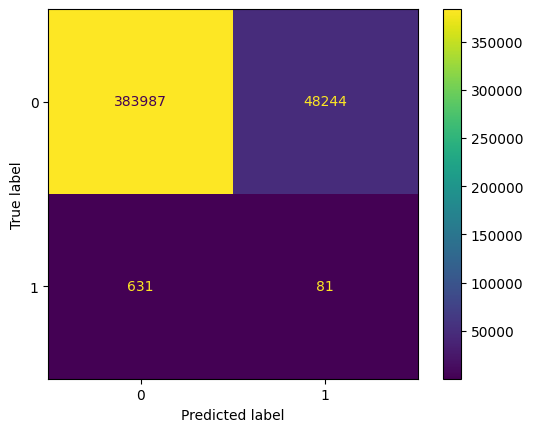

In [10]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Macro Viewpoint

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
# #Uncomment if you want to find new rules with different support

# start_time = time.time()
# ifthens_coverage_correctness, stats = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='gender',
#     freqitem_minsupp = 0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = False
# )
# end_time = time.time()

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [13]:
# stats["valid-if-thens-time"] = end_time - start_time
# stats["triples-no"] = len(ifthens_coverage_correctness)
# stats["subgroup-no"] = len(rules_by_if)

In [14]:
from facts.utils import load_rules_by_if, save_rules_by_if

# Use this for loading rules from disk
rules_by_if = load_rules_by_if(computed_rules_file)

## Use this for saving rules on disk
# save_rules_by_if(computed_rules_file, rules_by_if)

In [15]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If area = Unknown, income = <100K, parents = 1:
	Protected Subgroup 'Male', 1.48% covered
		Make income = >100K with correctness 2.76%.
	Protected Subgroup 'Female', 1.52% covered
		Make income = >100K with correctness 0.12%.
If area = Unknown, income = <100K, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 1.05% covered
		Make income = >100K with correctness 2.63%.
		Make religion = Christianity with correctness 0.00%.
		Make religion = Other with correctness 0.00%.
	Protected Subgroup 'Female', 1.05% covered
		Make income = >100K with correctness 0.12%.
		Make religion = Christianity with correctness 0.00%.
		Make religion = Other with correctness 0.00%.
If area = Unknown, college_educated = 1, income = <100K, parents = 1:
	Protected Subgroup 'Male', 1.40% covered
		Make income = >100K with correctness 2.49%.
	Protected Subgroup 'Female', 1.44% covered
		Make income = >100K with correctness 0.00%.
If college_educated = 1, income = <100K, parents = 1, religion = Unknown:


In [16]:
num_features = []
cate_features = ['religion','politics', 'parents', 'ages', 'income', 'area', 'college_educated', 'homeowner']
ord_features = []

feature_weights = {'religion':5,'politics':2, 'parents':3, 'ages':10, 'income':3, 'area':2, 'college_educated':3, 'homeowner':1}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=False,
)
params = ParameterProxy(featureChanges=comparators)

## Macro Viewpoint

In [17]:
all_selections_time = 0

### Equal Cost of Effectiveness (Macro)

In [18]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",        
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

all_selections_time += time.time() - start_time

With the given parameters, no recourses showing unfairness have been found!


### Equal Choice for Recourse

In [19]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

all_selections_time += time.time() - start_time

If ages = 25-34:
	Protected Subgroup 'Male', 2.05% covered out of 83109
		Make ages = 45-54 with effectiveness 31.03%.
		Aggregate cost of the above recourses = -1.00
	Protected Subgroup 'Female', 2.00% covered out of 161494
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 1.
If ages = 25-34, politics = Unknown:
	Protected Subgroup 'Male', 2.05% covered out of 83109
		Make ages = 45-54 with effectiveness 30.98%.
		Make ages = 55-64, politics = Moderate with effectiveness 100.00%.
		Aggregate cost of the above recourses = -2.00
	Protected Subgroup 'Female', 1.99% covered out of 161494
		Make ages = 55-64, politics = Moderate with effectiveness 100.00%.
		Aggregate cost of the above recourses = -1.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 1.
If ages = 25-34, income = Unknown:
	Protected Subgroup 'Male', 1.96% covered out of 83109
		Make ages = 45-54 with effect

## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [ ]:
# start_time = time.time()
# rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="gender", params=params)
# end_time = time.time()

100%|██████████████████████████████████████████████████████████████████████████████| 1280/1280 [04:50<00:00,  4.40it/s]


In [ ]:
# stats["cumulative-time"] = end_time - start_time

In [20]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if(computed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(computed_rules_with_cumulative_file, rules_with_cumulative)

# facts.update_costs_cumulative(rules_with_cumulative, params)

### Equal (Conditional) Mean Recourse

If ages = 25-34, area = Unknown, college_educated = 1:
	Protected Subgroup 'Male', 1.45% covered out of 83109
		Make ages = 55-64 with effectiveness 14.52% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.35% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.35% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 93.36% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 93.36% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 11.67
	Protected Subgroup 'Female', 1.41% covered out of 161494
		Make ages = 55-64 with effectiveness 15.00% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 16.02% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 16.02% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 29.69% and counterfactual cost = 12.0.
		Ma

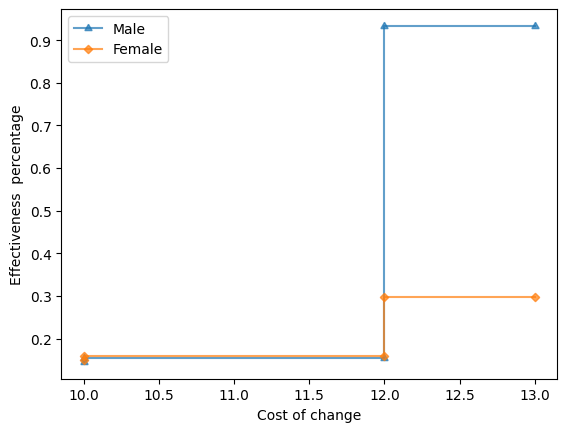

If ages = 25-34, area = Unknown, college_educated = 1, income = Unknown:
	Protected Subgroup 'Male', 1.38% covered out of 83109
		Make ages = 55-64 with effectiveness 13.11% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.90% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.90% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 94.76% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 94.76% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 94.76% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 94.76% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 11.71
	Protected Subgroup 'Female', 1.32% covered out of 161494
		Make ages = 55-64 with effectiveness 12.99% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.03% and counterfac

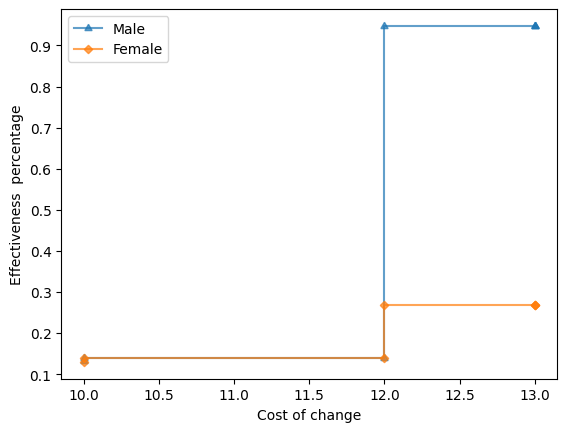

If ages = 25-34, area = Unknown:
	Protected Subgroup 'Male', 1.53% covered out of 83109
		Make ages = 55-64 with effectiveness 13.98% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.77% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 14.77% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 93.32% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 11.68
	Protected Subgroup 'Female', 1.48% covered out of 161494
		Make ages = 55-64 with effectiveness 14.39% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.36% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.36% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 32.52% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 11.06
	Bias against Male due to Equal Effectiveness. Unfairness score = 0.628.
	Cumu

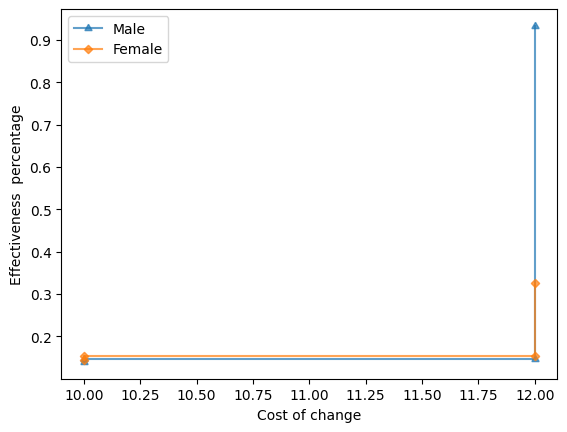

In [21]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

all_selections_time += time.time() - start_time

### Equal Effectiveness

If ages = 45-54, area = Unknown, college_educated = 1, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.03% covered out of 83109
		Make area = Urban with effectiveness 100.00% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 100.00% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 1.04% covered out of 161494
		Make area = Urban with effectiveness 15.33% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 15.33% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.33

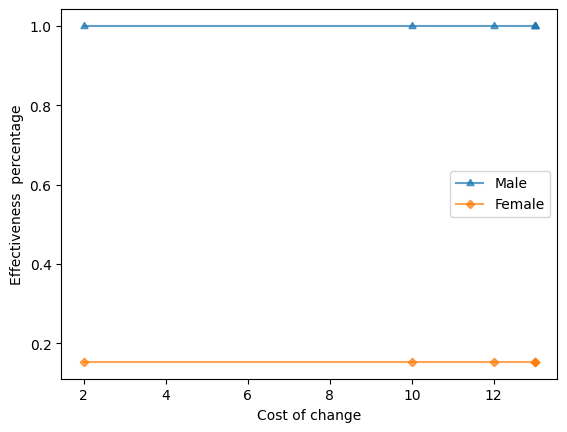

If ages = 45-54, area = Unknown, college_educated = 1, parents = 1:
	Protected Subgroup 'Male', 1.07% covered out of 83109
		Make area = Urban with effectiveness 98.08% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 98.08% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 98.08% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 98.08% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 0.98
	Protected Subgroup 'Female', 1.08% covered out of 161494
		Make area = Urban with effectiveness 16.45% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 16.45% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 16.45% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 16.45% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 0.16
	Bias against Female due to Equ

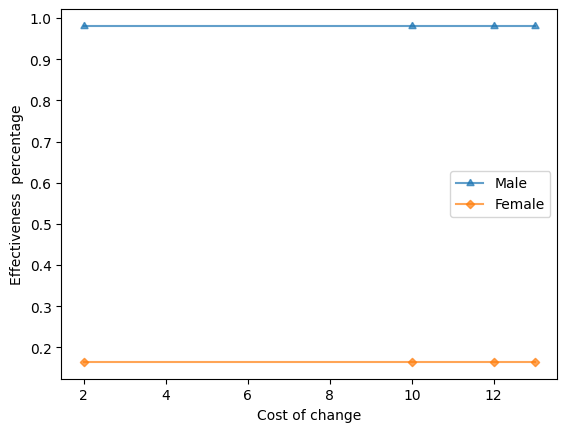

If ages = 45-54, area = Unknown, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.10% covered out of 83109
		Make area = Urban with effectiveness 100.00% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 1.11% covered out of 161494
		Make area = Urban with effectiveness 20.29% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 20.29% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 20.29% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 20.29% and counterfactual cost = 1

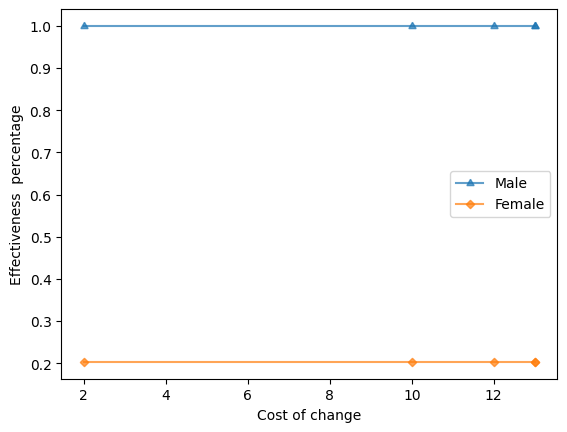

If ages = 45-54, area = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.13% covered out of 83109
		Make area = Urban with effectiveness 98.20% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 98.20% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 98.20% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 0.98
	Protected Subgroup 'Female', 1.15% covered out of 161494
		Make area = Urban with effectiveness 21.20% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 21.20% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 21.20% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 0.21
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.77.
	Cumulative effectiveness plot for the above recourses:


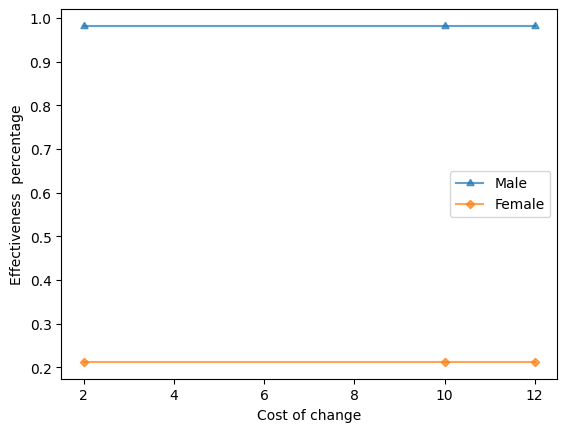

If ages = 25-34, area = Unknown, college_educated = 1, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.29% covered out of 83109
		Make ages = 55-64 with effectiveness 13.95% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.95% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.95% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 100.00% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 1.26% covered out of 161494
		Make ages = 55-64 with effectiveness 13.60% and counterfactual cost = 10.0.
		Make ages = 45-54 with

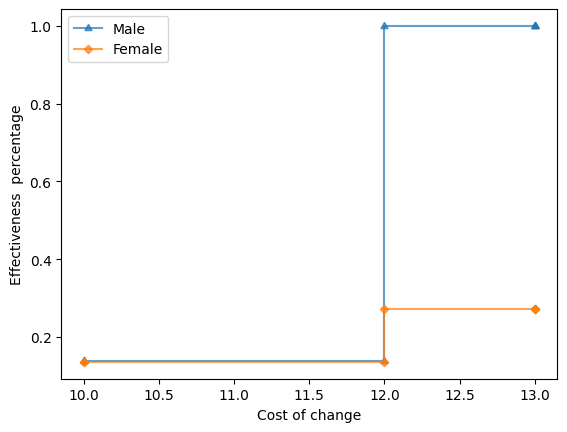

If ages = 25-34, area = Unknown, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.36% covered out of 83109
		Make ages = 55-64 with effectiveness 13.25% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.25% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.25% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 1.32% covered out of 161494
		Make ages = 55-64 with effectiveness 12.97% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 12.97% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 12.97% and count

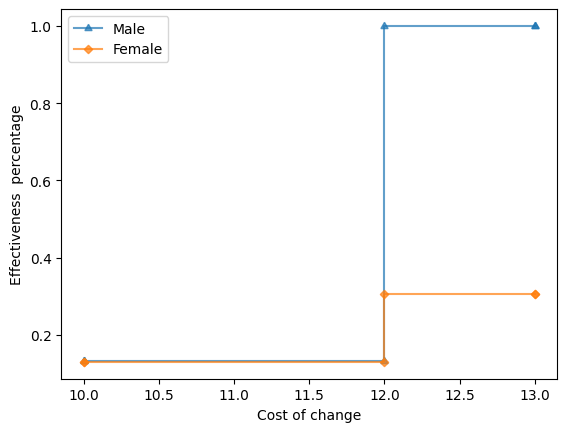

If ages = 25-34, area = Unknown, college_educated = 1, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.36% covered out of 83109
		Make ages = 55-64 with effectiveness 15.45% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.45% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.45% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 98.41% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 98.41% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 0.98
	Protected Subgroup 'Female', 1.35% covered out of 161494
		Make ages = 55-64 with effectiveness 15.71% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.71% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.71% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 30.03% and 

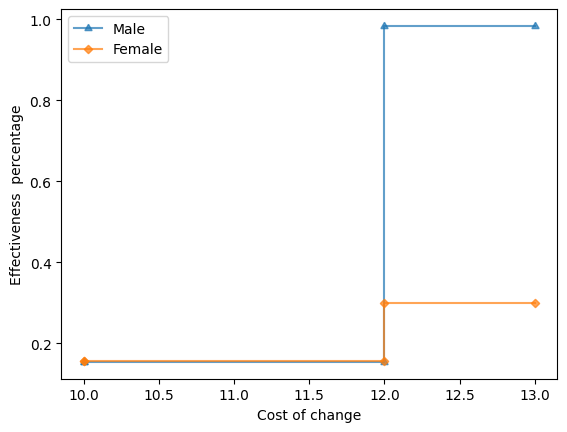

If ages = 25-34, area = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.44% covered out of 83109
		Make ages = 55-64 with effectiveness 14.88% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.88% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 14.88% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 98.49% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 0.98
	Protected Subgroup 'Female', 1.41% covered out of 161494
		Make ages = 55-64 with effectiveness 15.02% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.02% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.02% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 33.05% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 0.33
	Bias against Female due to Equal Effectiveness

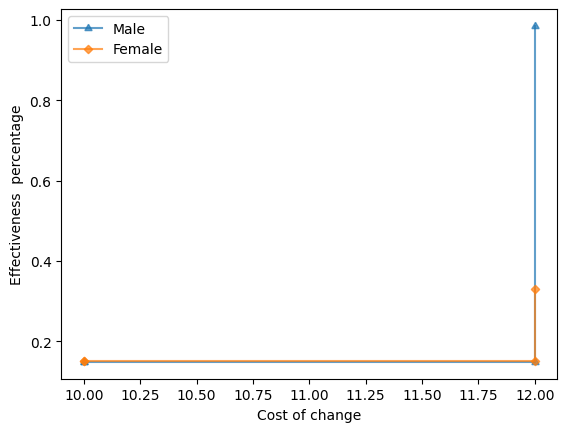

If ages = 25-34, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.23% covered out of 83109
		Make ages = 55-64 with effectiveness 10.97% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 32.52% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 32.52% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 32.52% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 32.52% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 32.52% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 32.52% and counterfactual cost = 15.0.
		Make ages = 55-64, income = <100K, religion = Christianity with effectiveness 32.52% and counterfactual cost = 18.0.
		Make ages = 55-64, income = <100K, religion = Other with effectiveness 

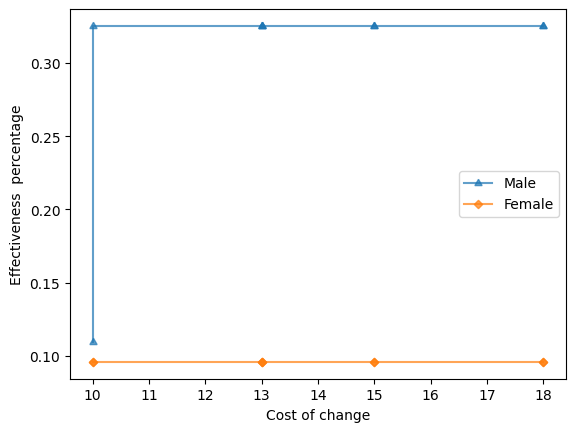

If ages = 25-34, college_educated = 1, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.28% covered out of 83109
		Make ages = 55-64 with effectiveness 12.31% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 33.27% and counterfactual cost = 10.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 33.27% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 33.27% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 33.27% and counterfactual cost = 15.0.
		Aggregate cost of the above recourses = 0.33
	Protected Subgroup 'Female', 1.25% covered out of 161494
		Make ages = 55-64 with effectiveness 11.40% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 11.40% and counterfactual cost = 10.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 11.40% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Chris

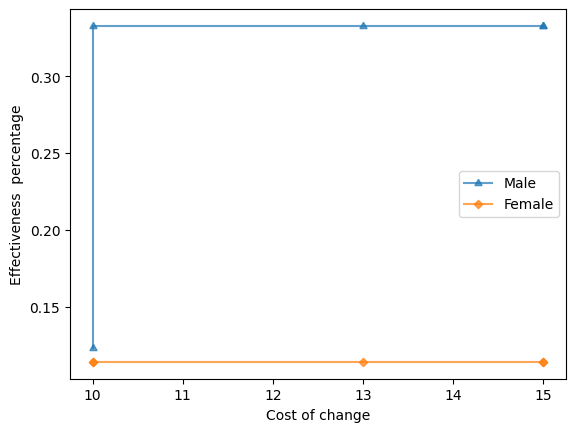

If ages = 25-34, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.29% covered out of 83109
		Make ages = 55-64 with effectiveness 10.44% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.97% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 31.97% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 31.97% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 31.97% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 31.97% and counterfactual cost = 15.0.
		Make ages = 55-64, income = <100K, religion = Christianity with effectiveness 31.97% and counterfactual cost = 18.0.
		Make ages = 55-64, income = <100K, religion = Other with effectiveness 31.97% and counterfactual cost = 18.0.
		Aggregate cost of the above recourses = 0.32
	Protected Subgroup 'Female', 1.24% 

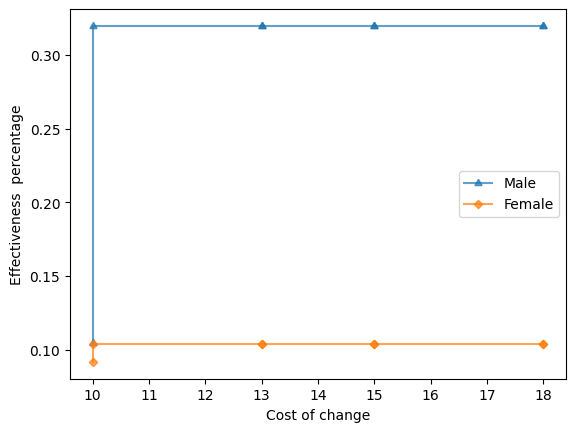

If ages = 25-34, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.35% covered out of 83109
		Make ages = 55-64 with effectiveness 11.71% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 32.62% and counterfactual cost = 10.0.
		Make ages = 55-64, religion = Christianity with effectiveness 32.62% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 32.62% and counterfactual cost = 15.0.
		Aggregate cost of the above recourses = 0.33
	Protected Subgroup 'Female', 1.31% covered out of 161494
		Make ages = 55-64 with effectiveness 10.89% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 12.03% and counterfactual cost = 10.0.
		Make ages = 55-64, religion = Christianity with effectiveness 12.03% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 12.03% and counterfactual cost = 15.0.
		Aggregate cost of the above recourses = 0.12
	Bias against

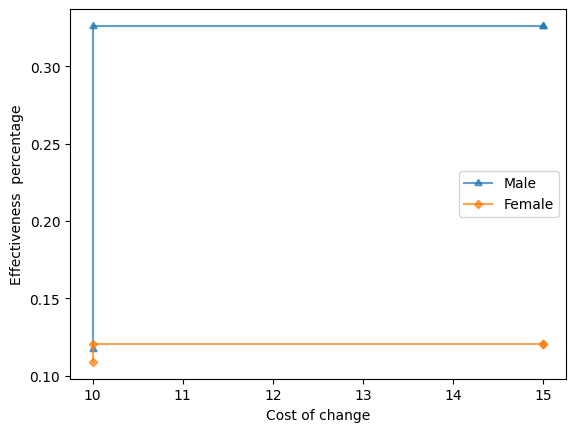

If ages = 25-34, college_educated = 1, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.76% covered out of 83109
		Make ages = 55-64 with effectiveness 10.34% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.99% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 31.99% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 31.99% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 31.99% and counterfactual cost = 13.0.
		Aggregate cost of the above recourses = 0.32
	Protected Subgroup 'Female', 1.73% covered out of 161494
		Make ages = 55-64 with effectiveness 9.95% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.10% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 14.10% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 14.10% and counterfact

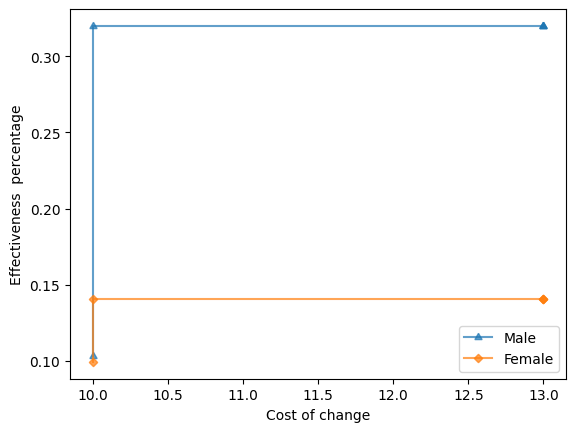

If homeowner = 0, income = Unknown:
	Protected Subgroup 'Male', 1.01% covered out of 83109
		Make homeowner = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = >100K with effectiveness 69.00% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 0.69
	Protected Subgroup 'Female', 1.02% covered out of 161494
		Make homeowner = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = >100K with effectiveness 51.38% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 0.51
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.176.
	Cumulative effectiveness plot for the above recourses:


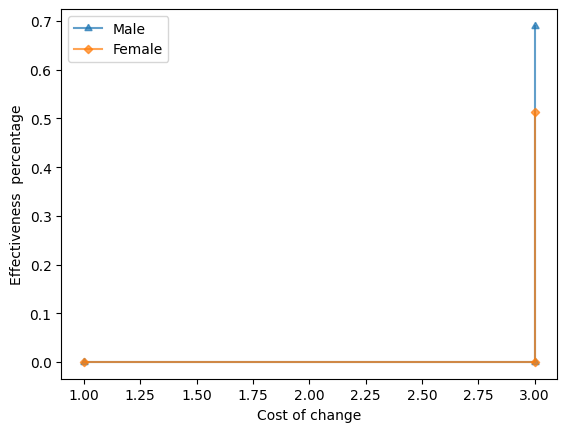

In [22]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

all_selections_time += time.time() - start_time

### Equal Cost of Effectiveness (micro)

If ages = 25-34, politics = Unknown:
	Protected Subgroup 'Male', 2.05% covered out of 83109
		Make ages = 55-64 with effectiveness 10.52% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 30.98% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Female', 1.99% covered out of 161494
		Make ages = 55-64 with effectiveness 10.70% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.36% and counterfactual cost = 10.0.
		Make ages = 55-64, politics = Moderate with effectiveness 100.00% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 12.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 2.0.
	Cumulative effectiveness plot for the above recourses:


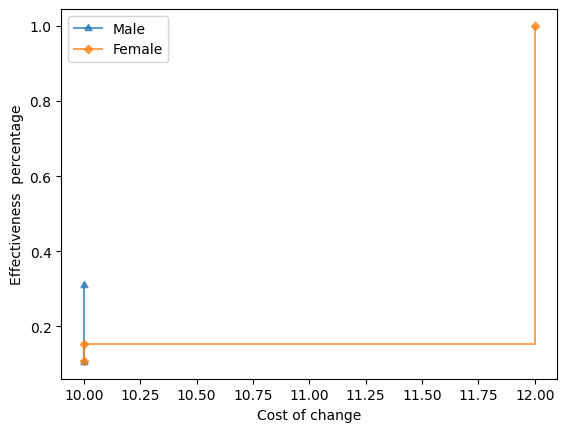

If ages = 25-34, income = Unknown, politics = Unknown:
	Protected Subgroup 'Male', 1.96% covered out of 83109
		Make ages = 55-64 with effectiveness 9.21% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 30.28% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Female', 1.89% covered out of 161494
		Make ages = 55-64 with effectiveness 9.10% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.98% and counterfactual cost = 10.0.
		Make ages = 55-64, politics = Moderate with effectiveness 100.00% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 12.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 2.0.
	Cumulative effectiveness plot for the above recourses:


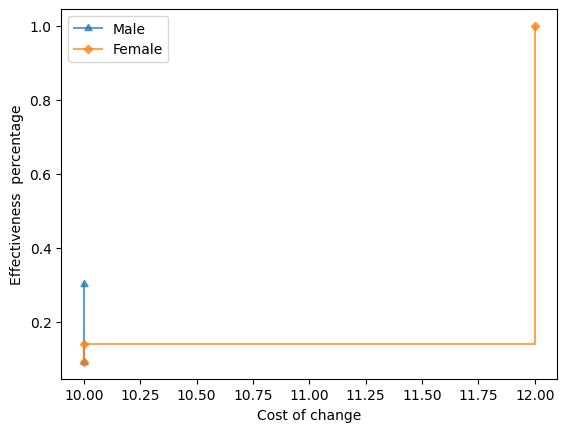

If ages = 25-34, college_educated = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.93% covered out of 83109
		Make ages = 55-64 with effectiveness 10.95% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.36% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Female', 1.90% covered out of 161494
		Make ages = 55-64 with effectiveness 11.16% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.04% and counterfactual cost = 10.0.
		Make ages = 55-64, politics = Moderate with effectiveness 100.00% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 12.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 2.0.
	Cumulative effectiveness plot for the above recourses:


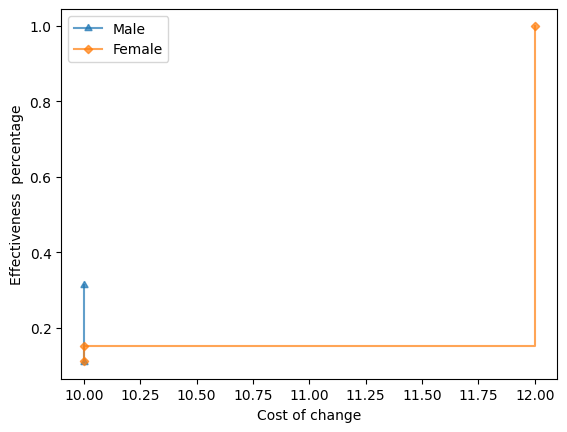

If ages = 25-34, college_educated = 1, income = Unknown, politics = Unknown:
	Protected Subgroup 'Male', 1.85% covered out of 83109
		Make ages = 55-64 with effectiveness 9.74% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 30.71% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'Female', 1.80% covered out of 161494
		Make ages = 55-64 with effectiveness 9.50% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.56% and counterfactual cost = 10.0.
		Make ages = 55-64, politics = Moderate with effectiveness 100.00% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 12.00
	Bias against Female due to Equal Effectiveness. Unfairness score = 2.0.
	Cumulative effectiveness plot for the above recourses:


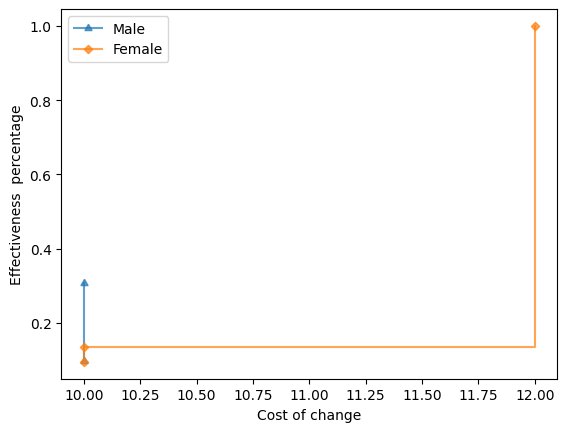

In [23]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

all_selections_time += time.time() - start_time

### Equal Effectiveness Within Budget

If ages = 45-54, area = Unknown, college_educated = 1, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.03% covered out of 83109
		Make area = Urban with effectiveness 100.00% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 1.04% covered out of 161494
		Make area = Urban with effectiveness 15.33% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 15.33% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.15
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.847.
	Cumulative effectiveness plot for the above recourses:


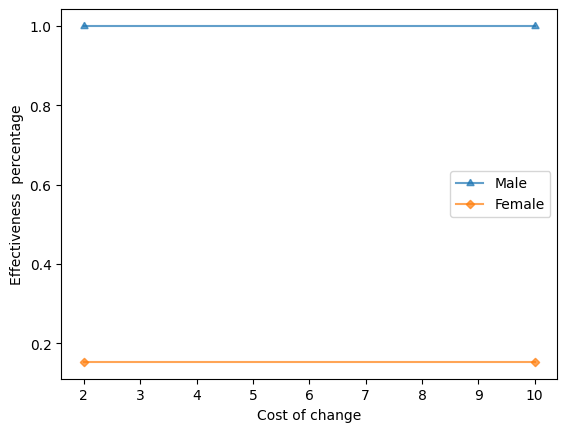

If ages = 45-54, area = Unknown, college_educated = 1, parents = 1:
	Protected Subgroup 'Male', 1.07% covered out of 83109
		Make area = Urban with effectiveness 98.08% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 98.08% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.98
	Protected Subgroup 'Female', 1.08% covered out of 161494
		Make area = Urban with effectiveness 16.45% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 16.45% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.16
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.816.
	Cumulative effectiveness plot for the above recourses:


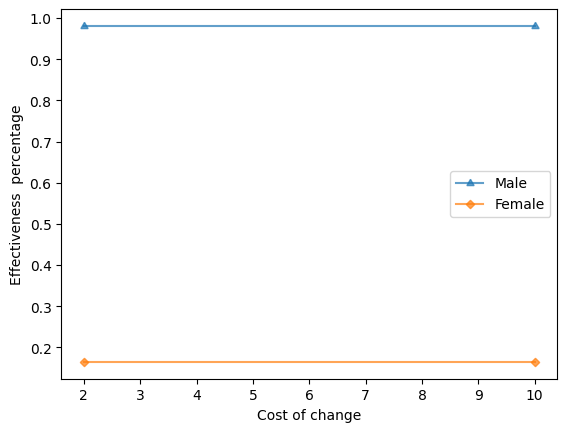

If ages = 45-54, area = Unknown, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.10% covered out of 83109
		Make area = Urban with effectiveness 100.00% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 100.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'Female', 1.11% covered out of 161494
		Make area = Urban with effectiveness 20.29% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 20.29% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.20
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.797.
	Cumulative effectiveness plot for the above recourses:


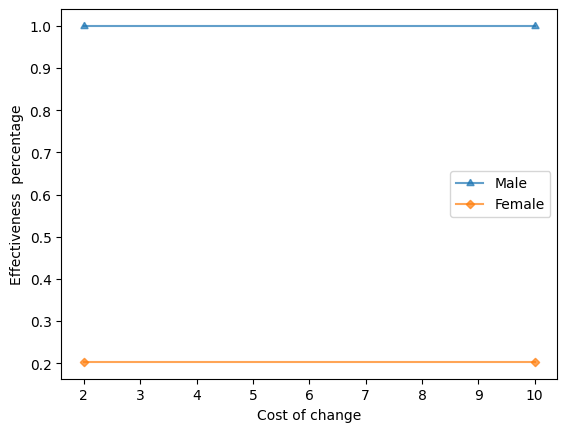

If ages = 45-54, area = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.13% covered out of 83109
		Make area = Urban with effectiveness 98.20% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 98.20% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.98
	Protected Subgroup 'Female', 1.15% covered out of 161494
		Make area = Urban with effectiveness 21.20% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 21.20% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.21
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.77.
	Cumulative effectiveness plot for the above recourses:


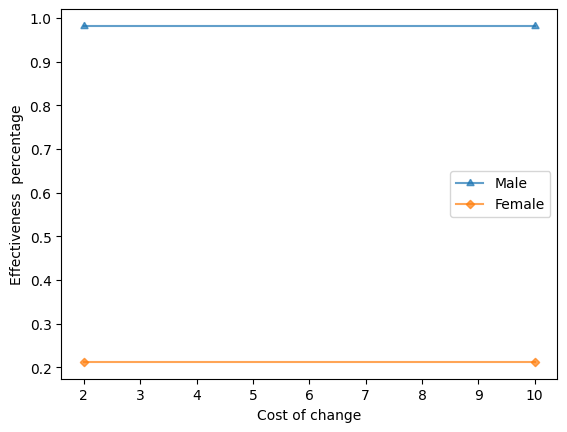

If ages = 25-34, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.23% covered out of 83109
		Make ages = 55-64 with effectiveness 10.97% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 32.52% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.33
	Protected Subgroup 'Female', 1.18% covered out of 161494
		Make ages = 55-64 with effectiveness 9.60% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 9.60% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.10
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.229.
	Cumulative effectiveness plot for the above recourses:


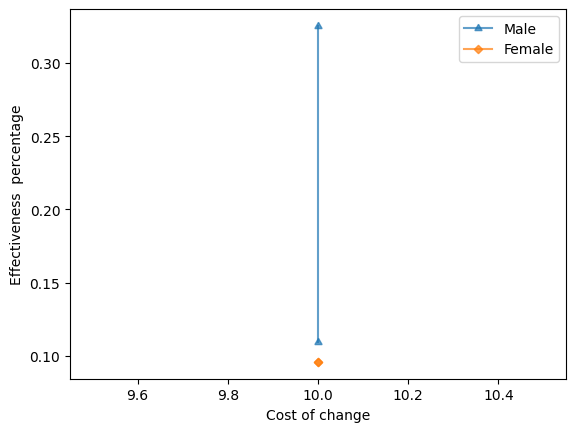

If ages = 25-34, college_educated = 1, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.28% covered out of 83109
		Make ages = 55-64 with effectiveness 12.31% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 33.27% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.33
	Protected Subgroup 'Female', 1.25% covered out of 161494
		Make ages = 55-64 with effectiveness 11.40% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 11.40% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.11
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.219.
	Cumulative effectiveness plot for the above recourses:


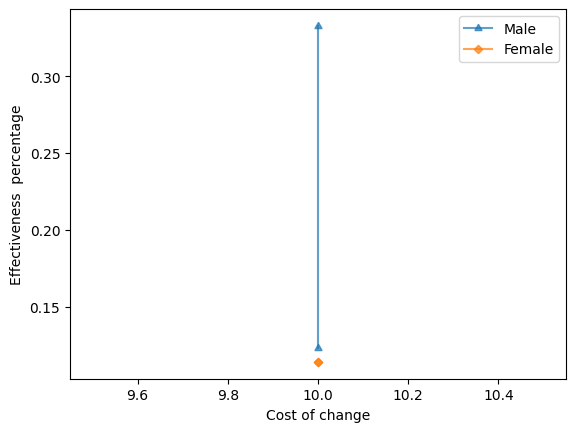

If ages = 25-34, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.29% covered out of 83109
		Make ages = 55-64 with effectiveness 10.44% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.97% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.32
	Protected Subgroup 'Female', 1.24% covered out of 161494
		Make ages = 55-64 with effectiveness 9.16% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 10.37% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.10
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.216.
	Cumulative effectiveness plot for the above recourses:


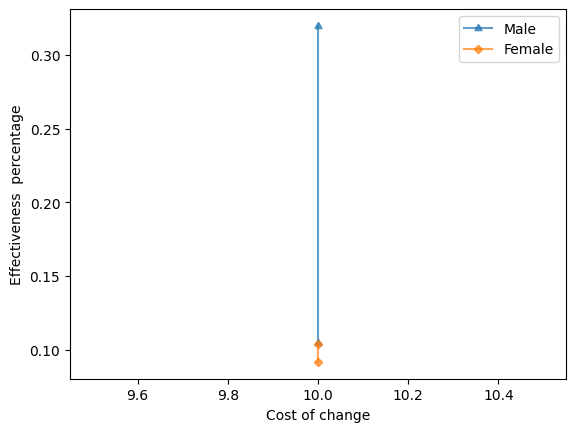

If ages = 25-34, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.35% covered out of 83109
		Make ages = 55-64 with effectiveness 11.71% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 32.62% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.33
	Protected Subgroup 'Female', 1.31% covered out of 161494
		Make ages = 55-64 with effectiveness 10.89% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 12.03% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.12
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.206.
	Cumulative effectiveness plot for the above recourses:


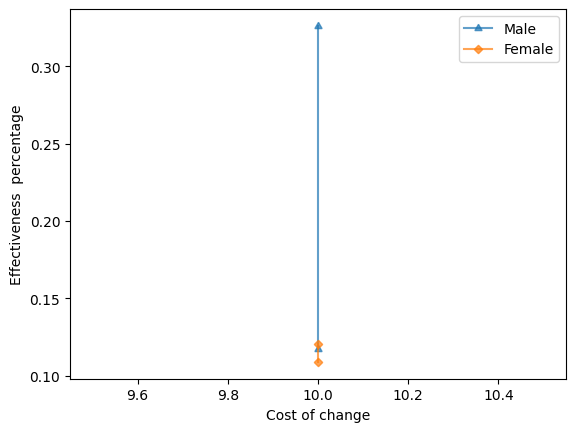

If ages = 25-34, college_educated = 1, homeowner = 1, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.57% covered out of 83109
		Make ages = 45-54 with effectiveness 24.12% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.24
	Protected Subgroup 'Female', 1.55% covered out of 161494
		Make ages = 45-54 with effectiveness 4.23% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.04
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.199.
	Cumulative effectiveness plot for the above recourses:


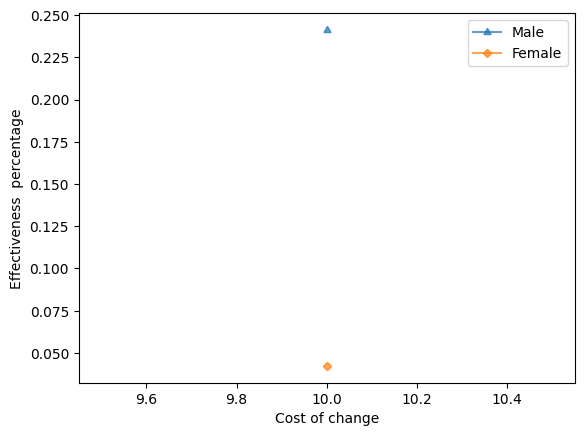

If ages = 25-34, college_educated = 1, homeowner = 1, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.62% covered out of 83109
		Make ages = 45-54 with effectiveness 23.74% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.24
	Protected Subgroup 'Female', 1.60% covered out of 161494
		Make ages = 45-54 with effectiveness 4.10% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.04
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.196.
	Cumulative effectiveness plot for the above recourses:


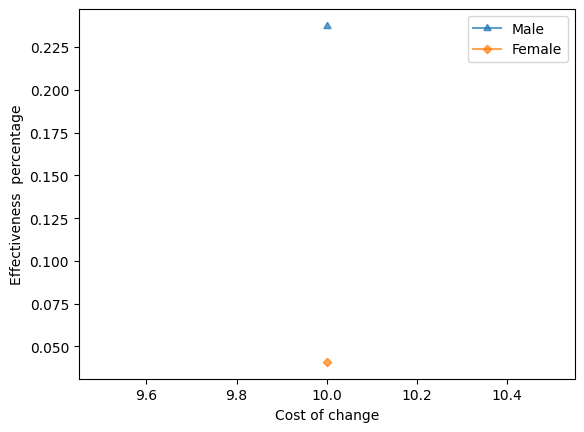

If ages = 25-34, homeowner = 1, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.66% covered out of 83109
		Make ages = 45-54 with effectiveness 24.22% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.24
	Protected Subgroup 'Female', 1.63% covered out of 161494
		Make ages = 45-54 with effectiveness 5.20% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.05
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.19.
	Cumulative effectiveness plot for the above recourses:


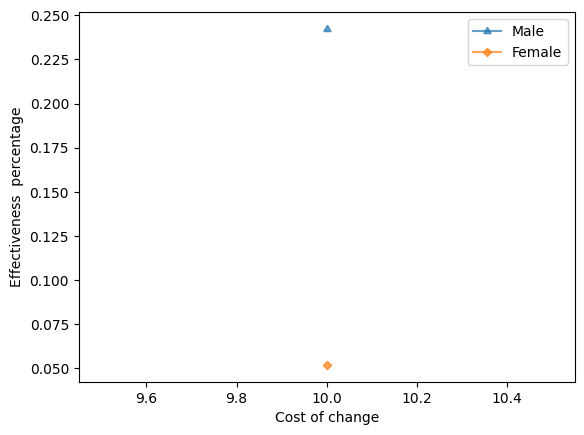

If ages = 25-34, homeowner = 1, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.71% covered out of 83109
		Make ages = 45-54 with effectiveness 23.81% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.24
	Protected Subgroup 'Female', 1.69% covered out of 161494
		Make ages = 45-54 with effectiveness 5.03% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.05
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.188.
	Cumulative effectiveness plot for the above recourses:


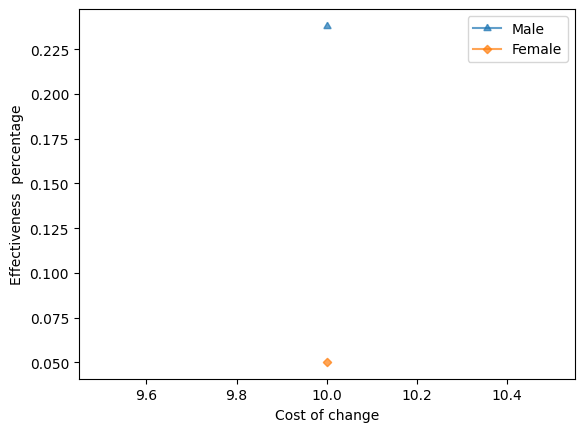

If ages = 25-34, college_educated = 1, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.75% covered out of 83109
		Make ages = 55-64 with effectiveness 10.30% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.94% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.32
	Protected Subgroup 'Female', 1.72% covered out of 161494
		Make ages = 55-64 with effectiveness 9.95% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.76% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.14
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.182.
	Cumulative effectiveness plot for the above recourses:


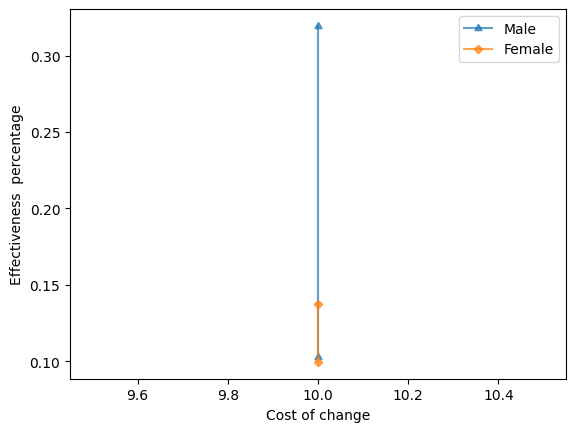

If ages = 25-34, college_educated = 1, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.76% covered out of 83109
		Make ages = 55-64 with effectiveness 10.34% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.99% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.32
	Protected Subgroup 'Female', 1.73% covered out of 161494
		Make ages = 55-64 with effectiveness 9.95% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.10% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 0.14
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.179.
	Cumulative effectiveness plot for the above recourses:


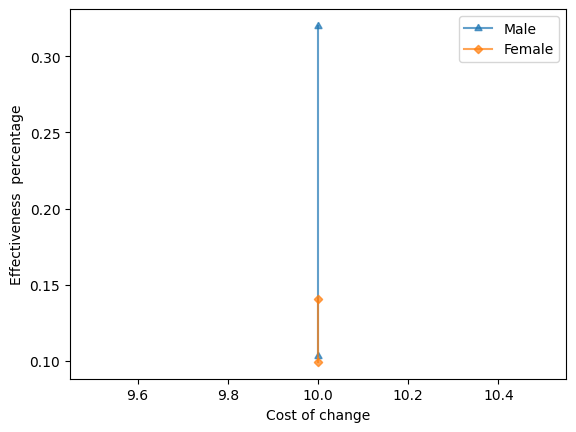

If homeowner = 0, income = Unknown:
	Protected Subgroup 'Male', 1.01% covered out of 83109
		Make homeowner = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = >100K with effectiveness 69.00% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 0.69
	Protected Subgroup 'Female', 1.02% covered out of 161494
		Make homeowner = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make income = <100K with effectiveness 0.00% and counterfactual cost = 3.0.
		Make income = >100K with effectiveness 51.38% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 0.51
	Bias against Female due to Equal Effectiveness. Unfairness score = 0.176.
	Cumulative effectiveness plot for the above recourses:


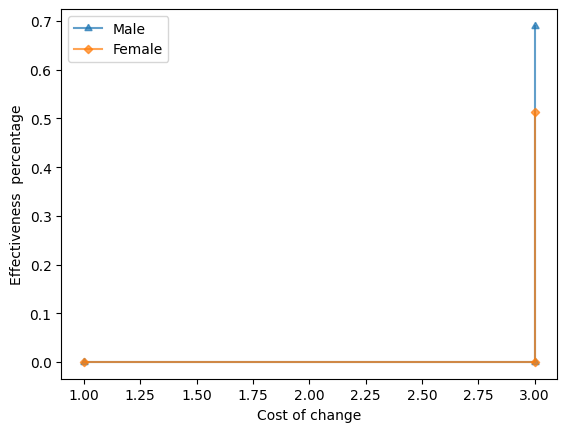

In [24]:
start_time = time.time()

top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

all_selections_time += time.time() - start_time

### Fair Effectiveness-Cost Trade-Off

If ages = 45-54, area = Unknown, college_educated = 1, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.03% covered out of 83109
		Make area = Urban with effectiveness 100.00% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 100.00% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.04% covered out of 161494
		Make area = Urban with effectiveness 15.33% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 15.33% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.33% and counterfactual cost = 12.0.
		Make ages =

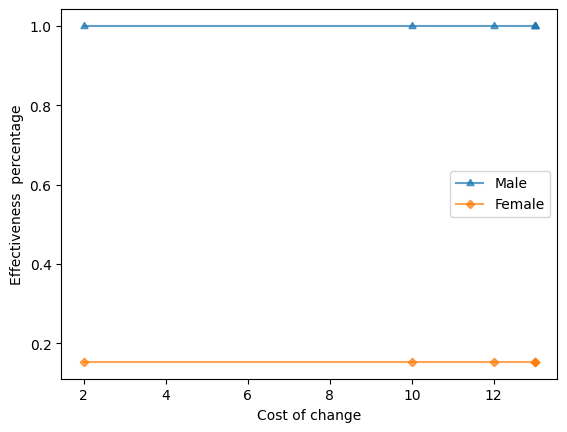

If ages = 45-54, area = Unknown, college_educated = 1, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.03% covered out of 83109
		Make area = Urban with effectiveness 100.00% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 100.00% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.04% covered out of 161494
		Make area = Urban with effectiveness 15.35% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 15.35% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.35% and counterfactual cost =

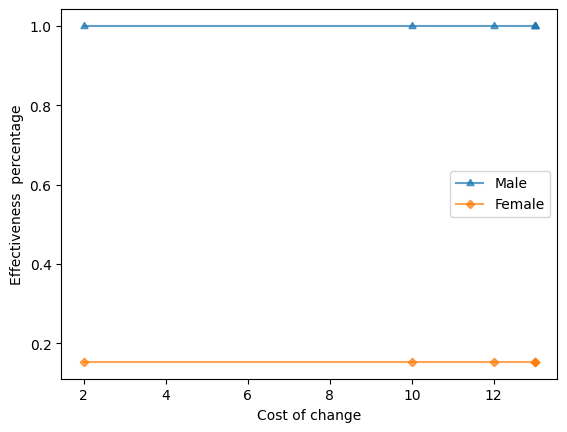

If ages = 45-54, area = Unknown, college_educated = 1, parents = 1:
	Protected Subgroup 'Male', 1.07% covered out of 83109
		Make area = Urban with effectiveness 98.08% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 98.08% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 98.08% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 98.08% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.08% covered out of 161494
		Make area = Urban with effectiveness 16.45% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 16.45% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 16.45% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 16.45% and counterfactual cost = 13.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 19.8.
	Cumulative effectiveness plot for the above recourses:


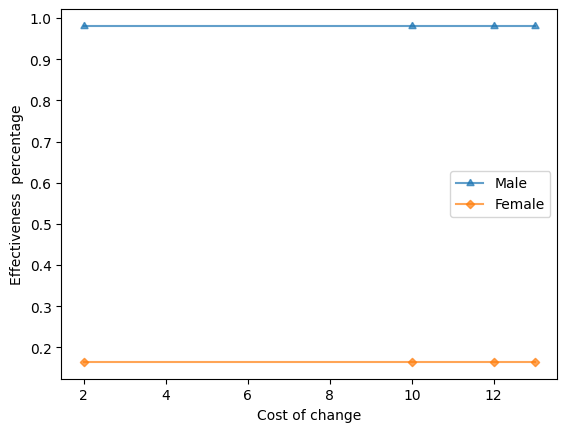

If ages = 45-54, area = Unknown, college_educated = 1, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.07% covered out of 83109
		Make area = Urban with effectiveness 98.08% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 98.08% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 98.08% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 98.08% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.08% covered out of 161494
		Make area = Urban with effectiveness 16.47% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 16.47% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 16.47% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 16.47% and counterfactual cost = 13.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 19.79.
	Cumulative effectiveness plot for t

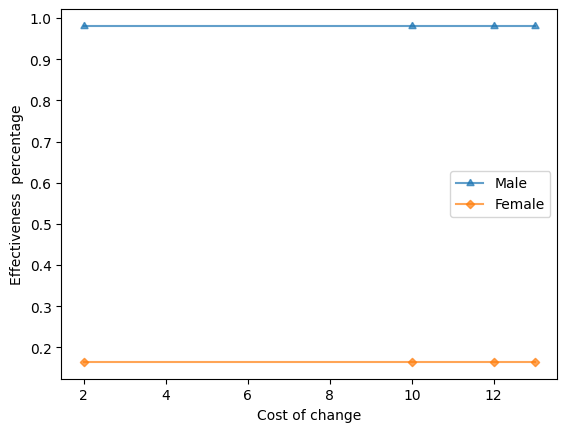

If ages = 45-54, area = Unknown, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.10% covered out of 83109
		Make area = Urban with effectiveness 100.00% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.11% covered out of 161494
		Make area = Urban with effectiveness 20.29% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 20.29% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 20.29% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 20.29% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with e

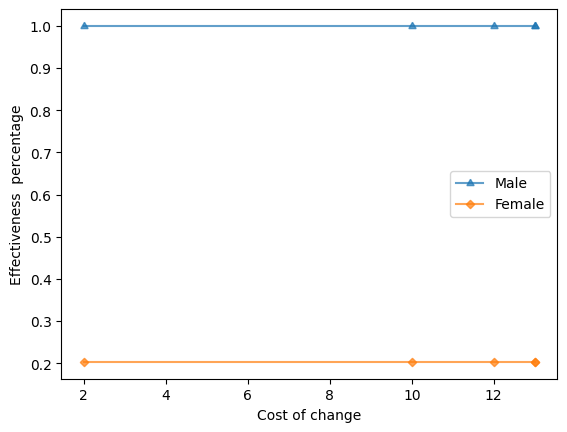

If ages = 45-54, area = Unknown, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.10% covered out of 83109
		Make area = Urban with effectiveness 100.00% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.11% covered out of 161494
		Make area = Urban with effectiveness 20.32% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 20.32% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 20.32% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 20.32% and counterfactual cost = 13.0.
		Make ages = 55-64, i

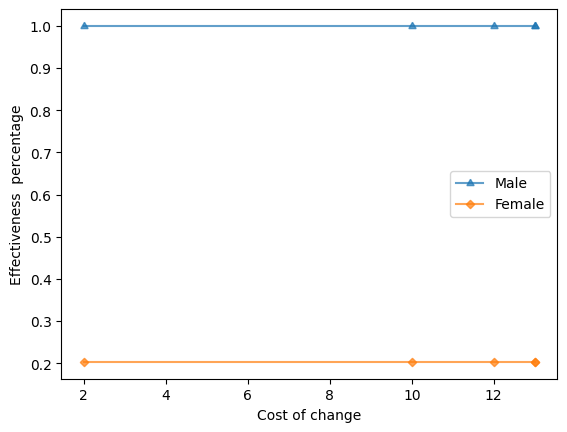

If ages = 45-54, area = Unknown, college_educated = 1, income = Unknown:
	Protected Subgroup 'Male', 1.10% covered out of 83109
		Make area = Urban with effectiveness 93.98% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 93.98% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 93.98% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 93.98% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 93.98% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 93.98% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.10% covered out of 161494
		Make area = Urban with effectiveness 14.52% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 14.52% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 14.52% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <1

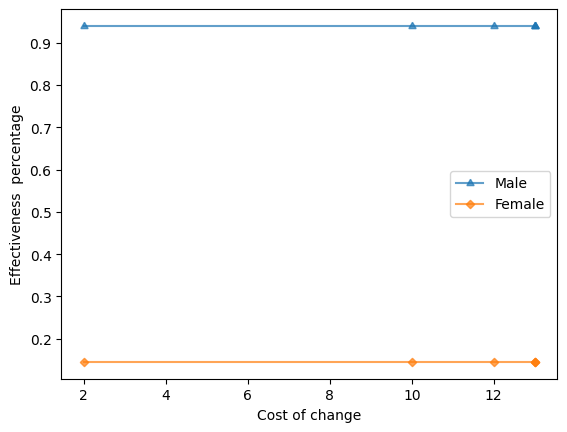

If ages = 45-54, area = Unknown, college_educated = 1, income = Unknown, politics = Unknown:
	Protected Subgroup 'Male', 1.10% covered out of 83109
		Make area = Urban with effectiveness 93.98% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 93.98% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 93.98% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 93.98% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 93.98% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 93.98% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.10% covered out of 161494
		Make area = Urban with effectiveness 14.54% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 14.54% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 14.54% and counterfactual cost = 12.0.
		Make ages 

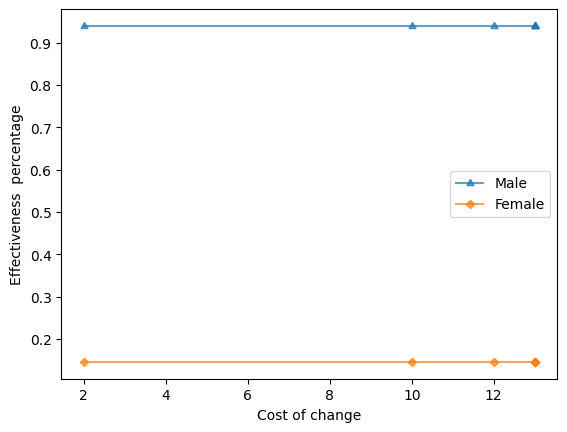

If ages = 25-34, area = Unknown, college_educated = 1, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.29% covered out of 83109
		Make ages = 55-64 with effectiveness 13.95% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.95% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.95% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 100.00% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.26% covered out of 161494
		Make ages = 55-64 with effectiveness 13.60% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.60% and counterfactual cost =

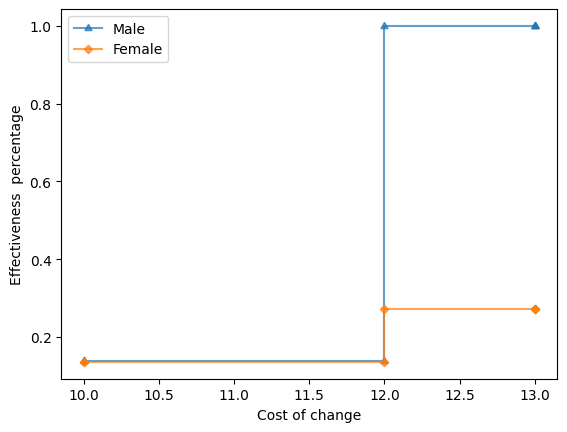

If ages = 45-54, area = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.13% covered out of 83109
		Make area = Urban with effectiveness 98.20% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 98.20% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 98.20% and counterfactual cost = 12.0.
	Protected Subgroup 'Female', 1.15% covered out of 161494
		Make area = Urban with effectiveness 21.20% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 21.20% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 21.20% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 19.25.
	Cumulative effectiveness plot for the above recourses:


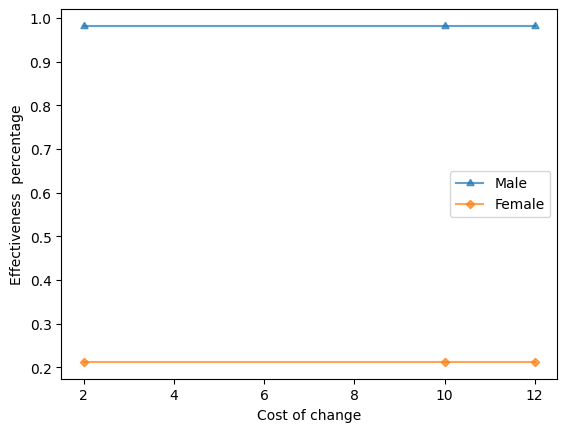

If ages = 45-54, area = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.13% covered out of 83109
		Make area = Urban with effectiveness 98.20% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 98.20% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 98.20% and counterfactual cost = 12.0.
	Protected Subgroup 'Female', 1.15% covered out of 161494
		Make area = Urban with effectiveness 21.22% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 21.22% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 21.22% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 19.24.
	Cumulative effectiveness plot for the above recourses:


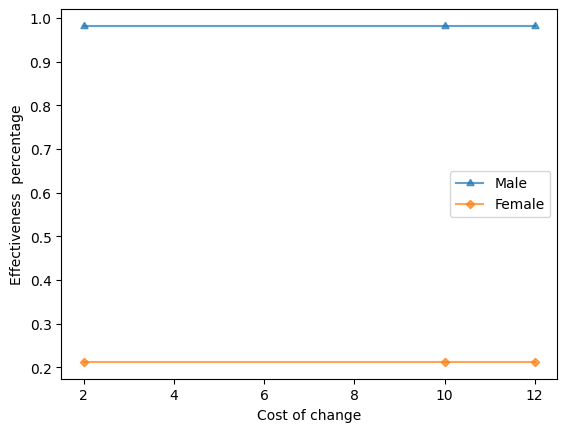

If ages = 25-34, area = Unknown, college_educated = 1, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.30% covered out of 83109
		Make ages = 55-64 with effectiveness 13.91% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.01% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 14.01% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 99.81% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 99.81% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 99.81% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 99.81% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.26% covered out of 161494
		Make ages = 55-64 with effectiveness 13.53% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.02% and counterfactual cost = 10.0.
		Make ages = 55-

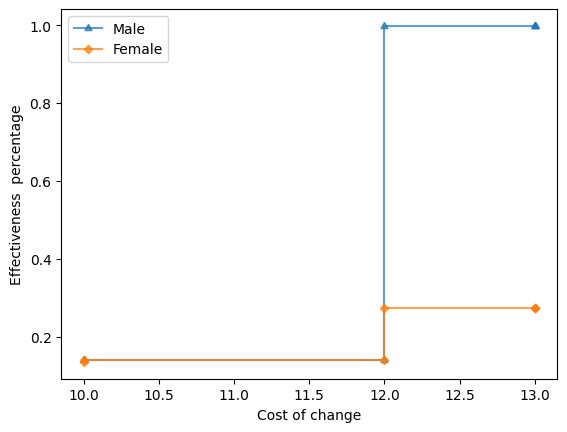

If ages = 45-54, area = Unknown, college_educated = 1:
	Protected Subgroup 'Male', 1.14% covered out of 83109
		Make area = Urban with effectiveness 92.06% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 92.06% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 92.06% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 92.06% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.14% covered out of 161494
		Make area = Urban with effectiveness 15.58% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 15.58% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.58% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 15.58% and counterfactual cost = 13.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 19.12.
	Cumulative effectiveness plot for the above recourses:


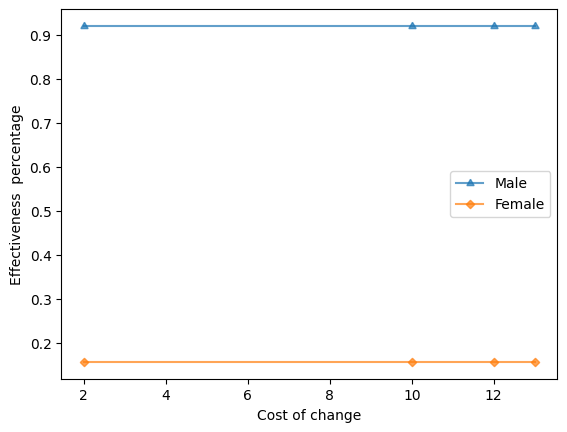

If ages = 45-54, area = Unknown, college_educated = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.14% covered out of 83109
		Make area = Urban with effectiveness 92.06% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 92.06% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 92.06% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 92.06% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.14% covered out of 161494
		Make area = Urban with effectiveness 15.60% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 15.60% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.60% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 15.60% and counterfactual cost = 13.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 19.11.
	Cumulative effectiveness plot for the above reco

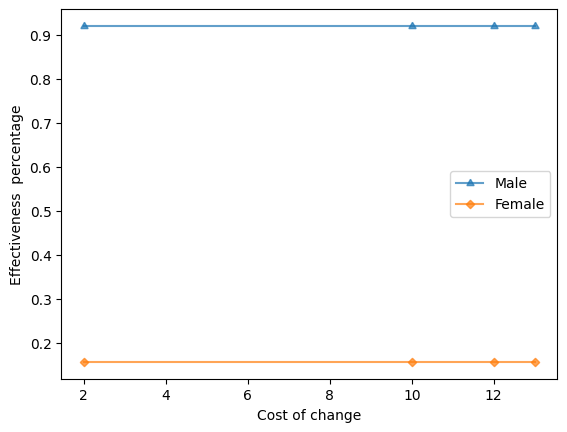

If ages = 45-54, area = Unknown, income = Unknown:
	Protected Subgroup 'Male', 1.17% covered out of 83109
		Make area = Urban with effectiveness 93.94% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 93.94% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 93.94% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 93.94% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 93.94% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.17% covered out of 161494
		Make area = Urban with effectiveness 19.25% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 19.25% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 19.25% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 19.25% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 19.25

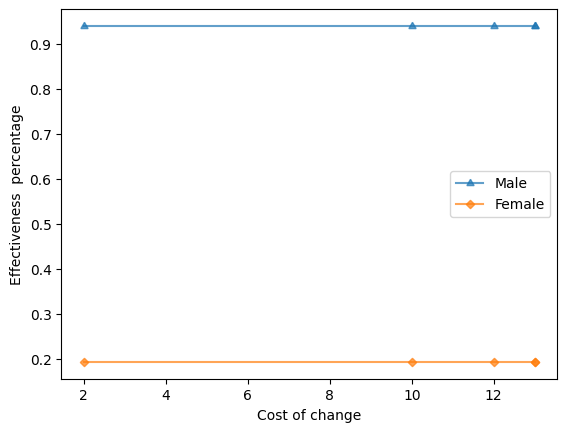

If ages = 45-54, area = Unknown, income = Unknown, politics = Unknown:
	Protected Subgroup 'Male', 1.17% covered out of 83109
		Make area = Urban with effectiveness 93.94% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 93.94% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 93.94% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 93.94% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 93.94% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.17% covered out of 161494
		Make area = Urban with effectiveness 19.27% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 19.27% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 19.27% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 19.27% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with

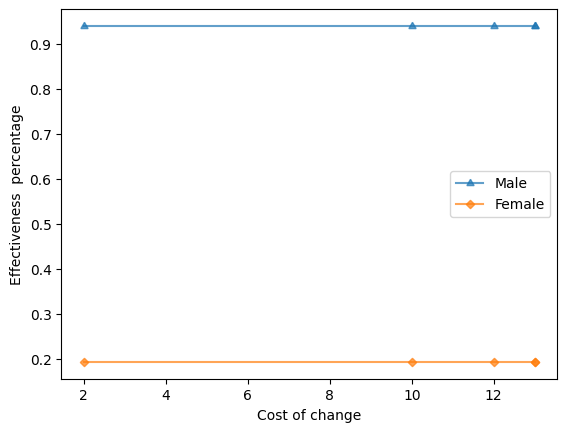

If ages = 25-34, area = Unknown, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.36% covered out of 83109
		Make ages = 55-64 with effectiveness 13.25% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.25% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.25% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 100.00% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 100.00% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.32% covered out of 161494
		Make ages = 55-64 with effectiveness 12.97% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 12.97% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 12.97% and counterfactual cost = 12.0.
		Make ages = 45-54, are

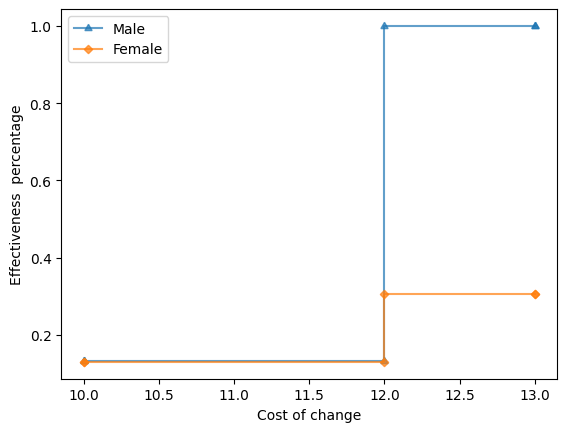

If ages = 25-34, area = Unknown, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.37% covered out of 83109
		Make ages = 55-64 with effectiveness 13.22% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.30% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.30% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 99.82% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 99.82% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 99.82% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.32% covered out of 161494
		Make ages = 55-64 with effectiveness 12.91% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.38% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.38% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiv

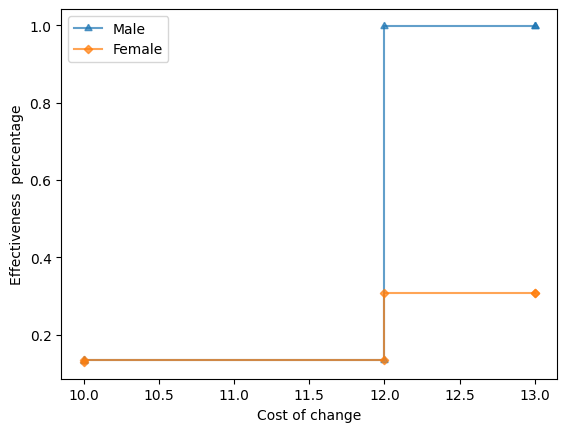

If ages = 25-34, area = Unknown, college_educated = 1, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.36% covered out of 83109
		Make ages = 55-64 with effectiveness 15.45% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.45% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.45% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 98.41% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 98.41% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.35% covered out of 161494
		Make ages = 55-64 with effectiveness 15.71% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.71% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.71% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 30.03% and counterfactual cost = 12.0.
		Make ages = 55-64

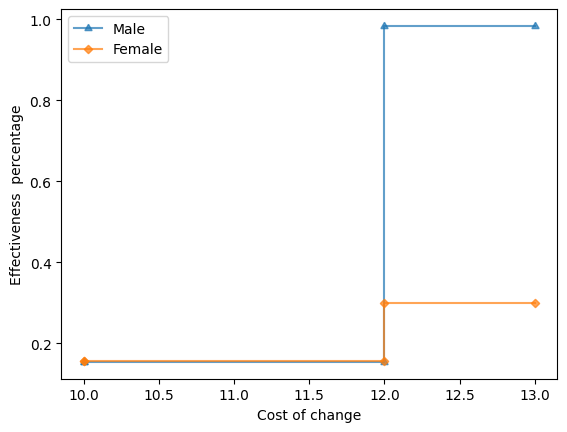

If ages = 25-34, area = Unknown, college_educated = 1, income = Unknown, politics = Unknown:
	Protected Subgroup 'Male', 1.37% covered out of 83109
		Make ages = 55-64 with effectiveness 13.15% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.85% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.85% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 94.92% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 94.92% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 94.92% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 94.92% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.31% covered out of 161494
		Make ages = 55-64 with effectiveness 13.05% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.62% and counterfactual cost = 10.0.
		Make age

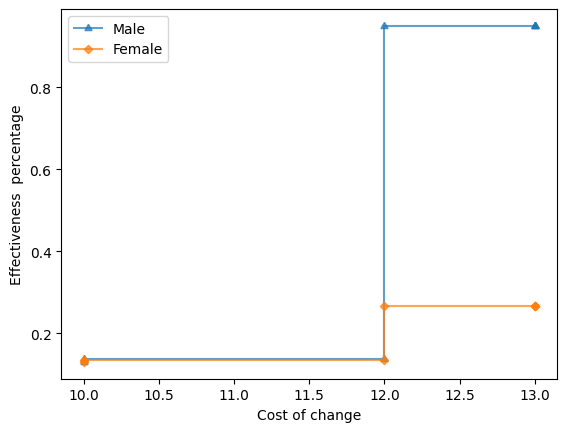

If ages = 25-34, area = Unknown, college_educated = 1, parents = 1:
	Protected Subgroup 'Male', 1.37% covered out of 83109
		Make ages = 55-64 with effectiveness 15.40% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.49% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.49% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 98.24% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 98.24% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.35% covered out of 161494
		Make ages = 55-64 with effectiveness 15.64% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 16.10% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 16.10% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 30.35% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated =

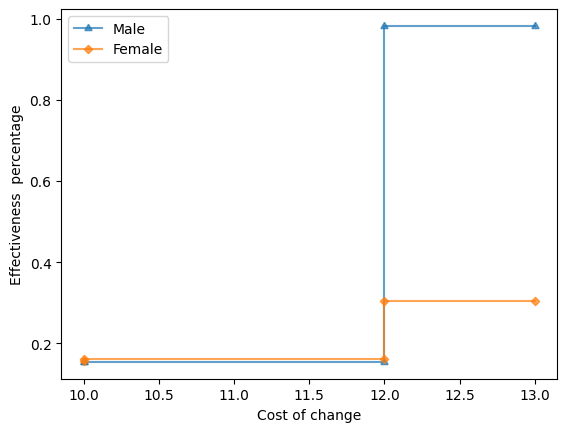

If ages = 45-54, area = Unknown:
	Protected Subgroup 'Male', 1.21% covered out of 83109
		Make area = Urban with effectiveness 92.14% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 92.14% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 92.14% and counterfactual cost = 12.0.
	Protected Subgroup 'Female', 1.21% covered out of 161494
		Make area = Urban with effectiveness 20.10% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 20.10% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 20.10% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 18.56.
	Cumulative effectiveness plot for the above recourses:


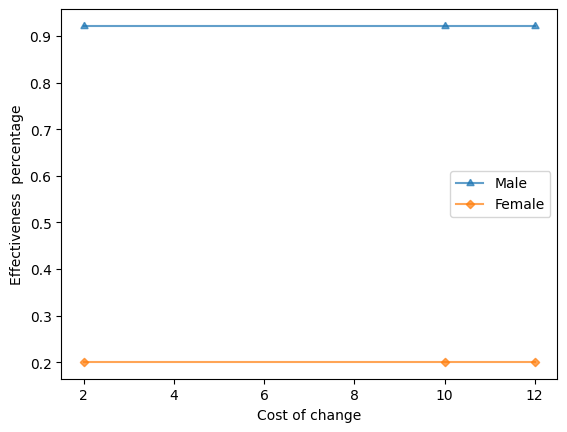

If ages = 45-54, area = Unknown, politics = Unknown:
	Protected Subgroup 'Male', 1.21% covered out of 83109
		Make area = Urban with effectiveness 92.14% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 92.14% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 92.14% and counterfactual cost = 12.0.
	Protected Subgroup 'Female', 1.21% covered out of 161494
		Make area = Urban with effectiveness 20.12% and counterfactual cost = 2.0.
		Make ages = 55-64 with effectiveness 20.12% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 20.12% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 18.55.
	Cumulative effectiveness plot for the above recourses:


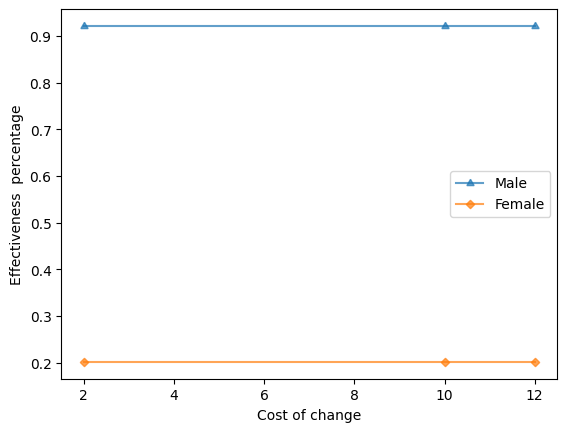

If ages = 25-34, area = Unknown, college_educated = 1, income = Unknown:
	Protected Subgroup 'Male', 1.38% covered out of 83109
		Make ages = 55-64 with effectiveness 13.11% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.90% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.90% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 94.76% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 94.76% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 94.76% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 94.76% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.32% covered out of 161494
		Make ages = 55-64 with effectiveness 12.99% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.03% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Ur

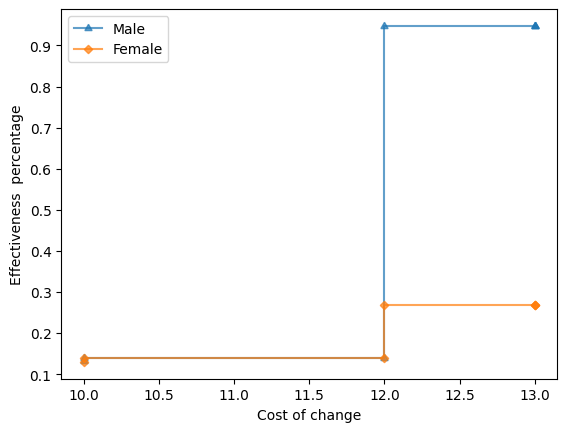

If ages = 25-34, area = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.44% covered out of 83109
		Make ages = 55-64 with effectiveness 14.88% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.88% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 14.88% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 98.49% and counterfactual cost = 12.0.
	Protected Subgroup 'Female', 1.41% covered out of 161494
		Make ages = 55-64 with effectiveness 15.02% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.02% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.02% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 33.05% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 18.33.
	Cumulative effectiveness plot for the above recourses:


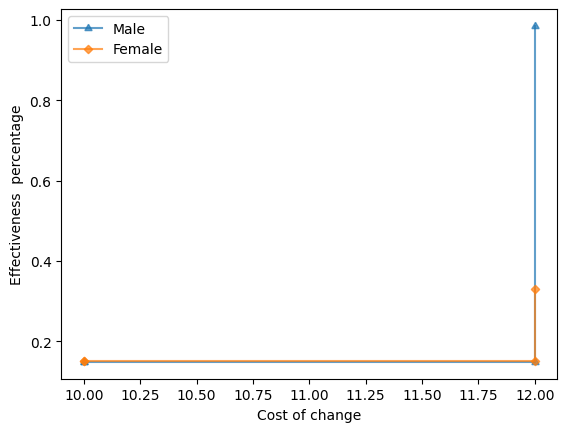

If ages = 25-34, area = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.44% covered out of 83109
		Make ages = 55-64 with effectiveness 14.85% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.93% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 14.93% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 98.33% and counterfactual cost = 12.0.
	Protected Subgroup 'Female', 1.42% covered out of 161494
		Make ages = 55-64 with effectiveness 14.96% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.40% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.40% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 33.35% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 18.23.
	Cumulative effectiveness plot for the above recourses:


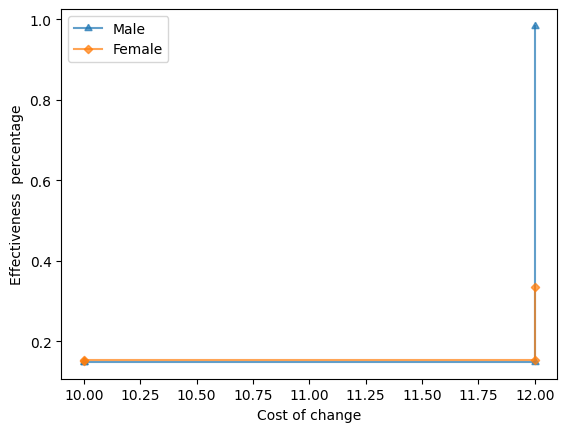

If ages = 25-34, area = Unknown, income = Unknown, politics = Unknown:
	Protected Subgroup 'Male', 1.45% covered out of 83109
		Make ages = 55-64 with effectiveness 12.47% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.13% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.13% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 94.76% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 94.76% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 94.76% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.38% covered out of 161494
		Make ages = 55-64 with effectiveness 12.50% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.04% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.04% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with e

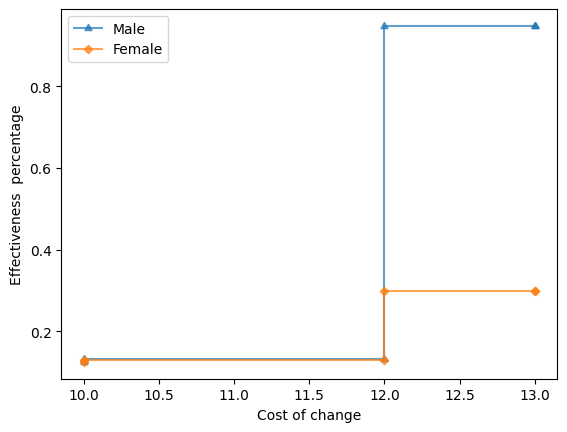

If ages = 25-34, area = Unknown, income = Unknown:
	Protected Subgroup 'Male', 1.45% covered out of 83109
		Make ages = 55-64 with effectiveness 12.44% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.18% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.18% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 94.61% and counterfactual cost = 12.0.
		Make ages = 55-64, income = <100K with effectiveness 94.61% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 94.61% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.38% covered out of 161494
		Make ages = 55-64 with effectiveness 12.44% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 13.44% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 13.44% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 30.07% 

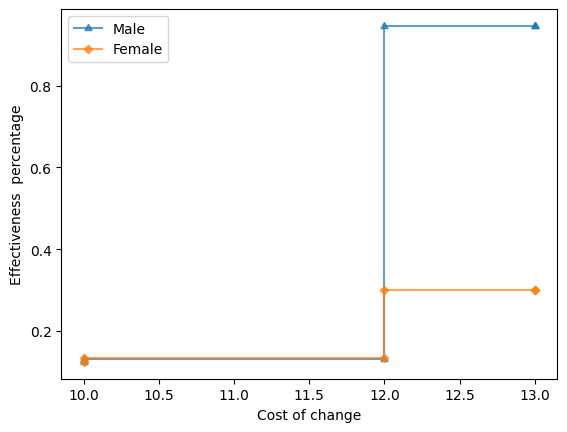

If ages = 25-34, area = Unknown, college_educated = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.45% covered out of 83109
		Make ages = 55-64 with effectiveness 14.56% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.31% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.31% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 93.51% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 93.51% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.40% covered out of 161494
		Make ages = 55-64 with effectiveness 15.07% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.64% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.64% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 29.38% and counterfactual cost = 12.0.
		Make ages = 55-64, college_edu

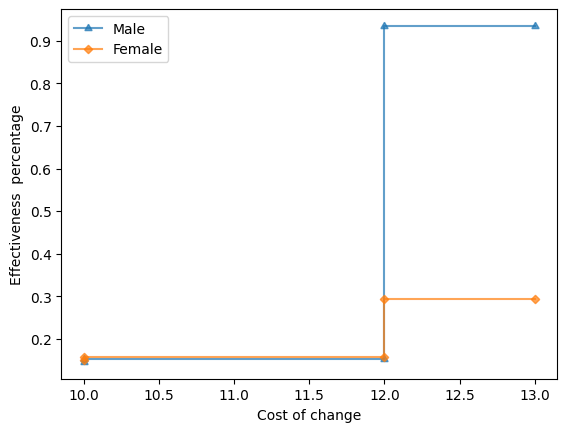

If ages = 25-34, area = Unknown, college_educated = 1:
	Protected Subgroup 'Male', 1.45% covered out of 83109
		Make ages = 55-64 with effectiveness 14.52% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.35% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.35% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 93.36% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 93.36% and counterfactual cost = 13.0.
	Protected Subgroup 'Female', 1.41% covered out of 161494
		Make ages = 55-64 with effectiveness 15.00% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 16.02% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 16.02% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 29.69% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0 with effec

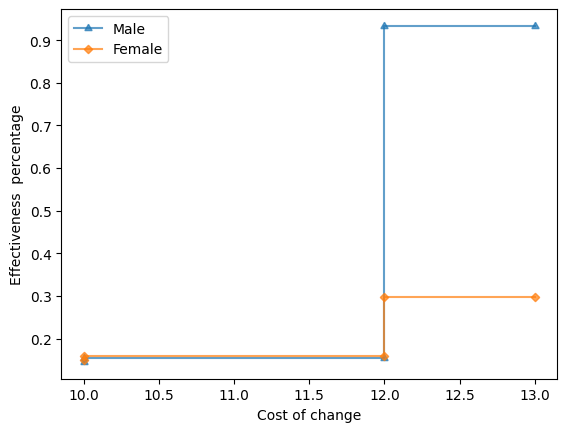

If ages = 25-34, area = Unknown, politics = Unknown:
	Protected Subgroup 'Male', 1.53% covered out of 83109
		Make ages = 55-64 with effectiveness 14.02% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.72% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 14.72% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 93.46% and counterfactual cost = 12.0.
	Protected Subgroup 'Female', 1.48% covered out of 161494
		Make ages = 55-64 with effectiveness 14.45% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.00% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.00% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 32.23% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 17.63.
	Cumulative effectiveness plot for the above recourses:


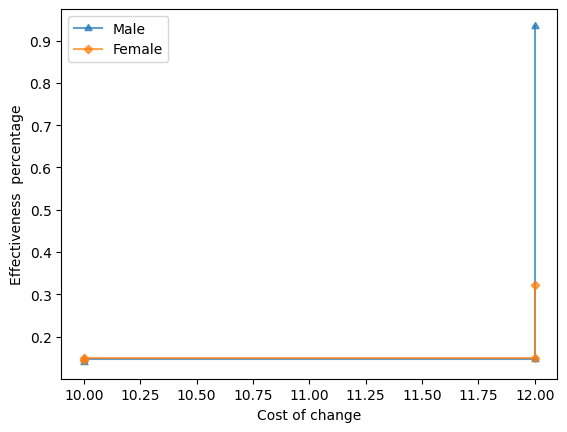

If ages = 25-34, area = Unknown:
	Protected Subgroup 'Male', 1.53% covered out of 83109
		Make ages = 55-64 with effectiveness 13.98% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 14.77% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 14.77% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 93.32% and counterfactual cost = 12.0.
	Protected Subgroup 'Female', 1.48% covered out of 161494
		Make ages = 55-64 with effectiveness 14.39% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 15.36% and counterfactual cost = 10.0.
		Make ages = 55-64, area = Urban with effectiveness 15.36% and counterfactual cost = 12.0.
		Make ages = 45-54, area = Urban with effectiveness 32.52% and counterfactual cost = 12.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 17.53.
	Cumulative effectiveness plot for the above recourses:


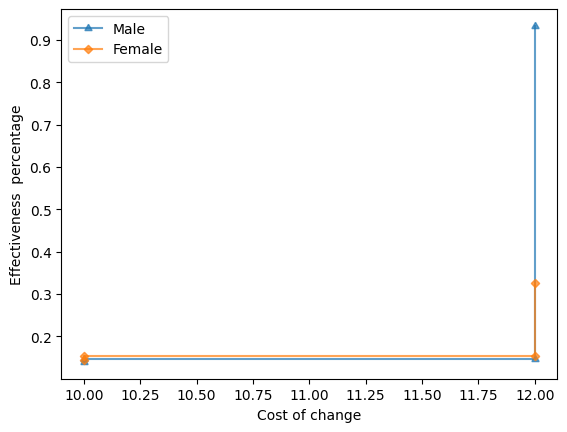

If ages = 25-34, college_educated = 1, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.23% covered out of 83109
		Make ages = 55-64 with effectiveness 10.97% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 32.52% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 32.52% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 32.52% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 32.52% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 32.52% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 32.52% and counterfactual cost = 15.0.
		Make ages = 55-64, income = <100K, religion = Christianity with effectiveness 32.52% and counterfactual cost = 18.0.
		Make ages = 55-64, income = <100K, religion = Other with effectiveness 

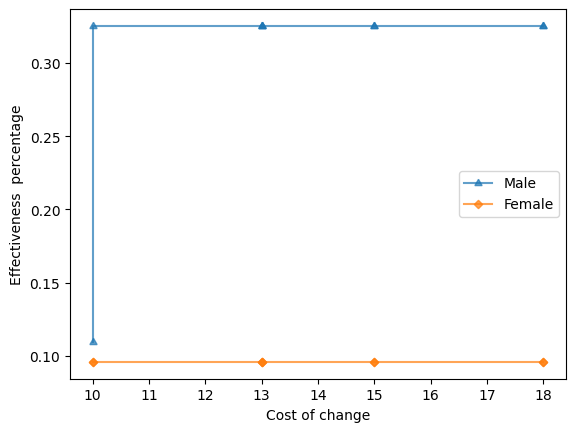

If ages = 25-34, college_educated = 1, homeowner = 1, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.62% covered out of 83109
		Make ages = 45-54 with effectiveness 23.74% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 55-64, college_educated = 0, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 14.0.
	Protected Subgroup 'Female', 1.60% covered out of 161494
		Make ages = 45-54 with effectiveness 4.10% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 55-64, college_educated = 0, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 14.0.
	 Unfairness based on the Fair Effect

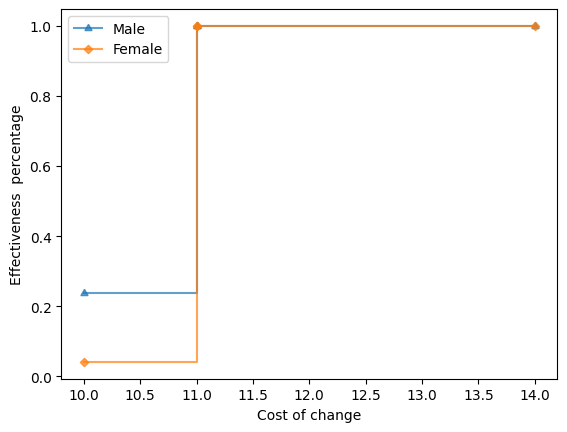

If ages = 25-34, college_educated = 1, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 1.23% covered out of 83109
		Make ages = 55-64 with effectiveness 10.96% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 32.49% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 32.49% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 32.49% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 32.49% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 32.49% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 32.49% and counterfactual cost = 15.0.
		Make ages = 55-64, income = <100K, religion = Christianity with effectiveness 32.49% and counterfactual cost = 18.0.
		Make ages = 55-64, income = <100K, religion = Other with effectiveness 32.49% and counterfa

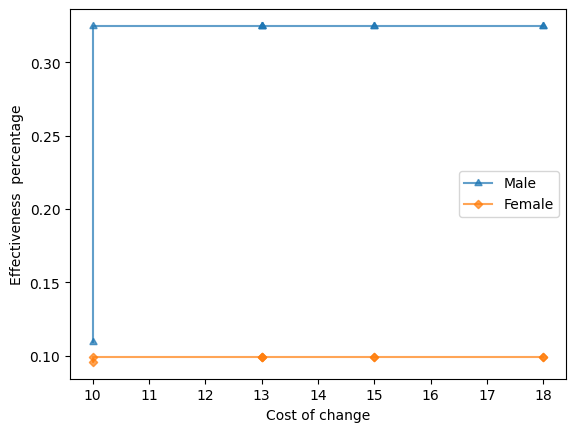

If ages = 25-34, college_educated = 1, homeowner = 1, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.57% covered out of 83109
		Make ages = 45-54 with effectiveness 24.12% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 55-64, homeowner = 0, income = <100K with effectiveness 100.00% and counterfactual cost = 14.0.
		Make ages = 55-64, homeowner = 0, income = >100K with effectiveness 100.00% and counterfactual cost = 14.0.
		Make ages = 55-64, college_educated = 0, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 14.0.
	Protected Subgroup 'Female', 1.55% covered out of 161494
		Make ages = 45-54 with effectiveness 4.23% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ag

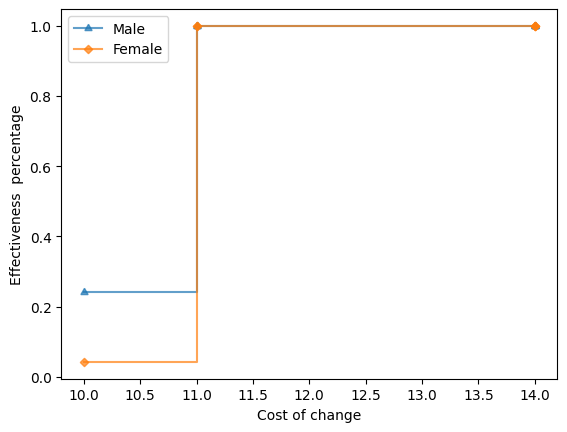

If ages = 25-34, college_educated = 1, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.28% covered out of 83109
		Make ages = 55-64 with effectiveness 12.31% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 33.27% and counterfactual cost = 10.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 33.27% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 33.27% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 33.27% and counterfactual cost = 15.0.
	Protected Subgroup 'Female', 1.25% covered out of 161494
		Make ages = 55-64 with effectiveness 11.40% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 11.40% and counterfactual cost = 10.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 11.40% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 11.40% and counterfa

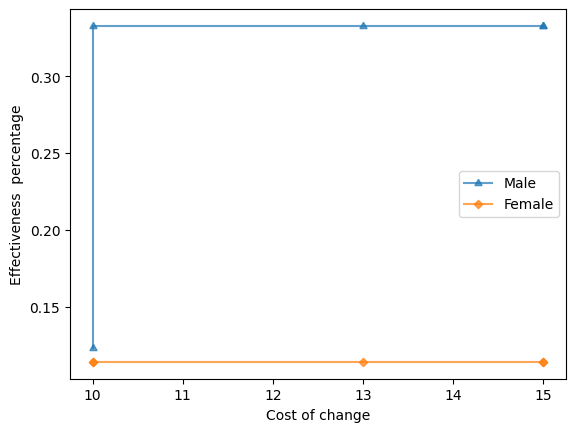

If ages = 25-34, college_educated = 1, homeowner = 1, parents = 1:
	Protected Subgroup 'Male', 1.62% covered out of 83109
		Make ages = 55-64 with effectiveness 0.07% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 23.81% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 99.85% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 99.85% and counterfactual cost = 11.0.
		Make ages = 55-64, college_educated = 0, homeowner = 0 with effectiveness 99.85% and counterfactual cost = 14.0.
	Protected Subgroup 'Female', 1.61% covered out of 161494
		Make ages = 55-64 with effectiveness 0.04% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 4.51% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 55-64, c

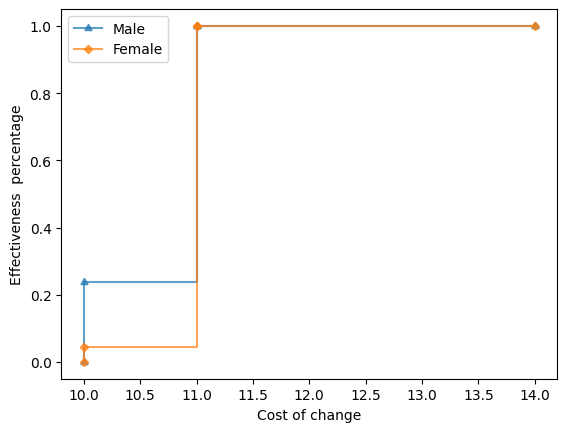

If ages = 25-34, homeowner = 1, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.71% covered out of 83109
		Make ages = 45-54 with effectiveness 23.81% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
	Protected Subgroup 'Female', 1.69% covered out of 161494
		Make ages = 45-54 with effectiveness 5.03% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 5.74.
	Cumulative effectiveness plot for the above recourses:


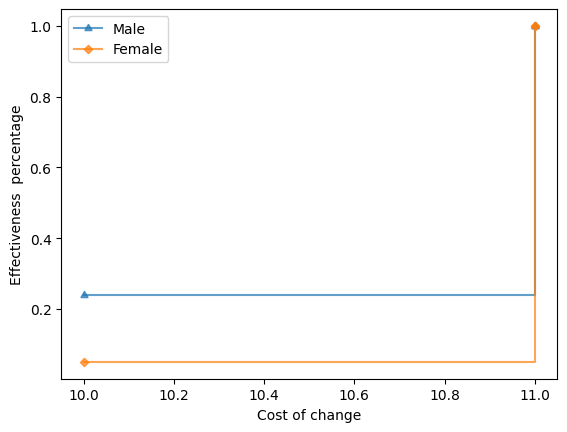

If ages = 25-34, college_educated = 1, homeowner = 1, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.58% covered out of 83109
		Make ages = 55-64 with effectiveness 0.08% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 24.20% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 99.85% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 99.85% and counterfactual cost = 11.0.
		Make ages = 55-64, homeowner = 0, income = <100K with effectiveness 99.85% and counterfactual cost = 14.0.
		Make ages = 55-64, homeowner = 0, income = >100K with effectiveness 99.85% and counterfactual cost = 14.0.
		Make ages = 55-64, college_educated = 0, homeowner = 0 with effectiveness 99.85% and counterfactual cost = 14.0.
	Protected Subgroup 'Female', 1.55% covered out of 161494
		Make ages = 55-64 with effectiveness 0.04% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 4.66% and co

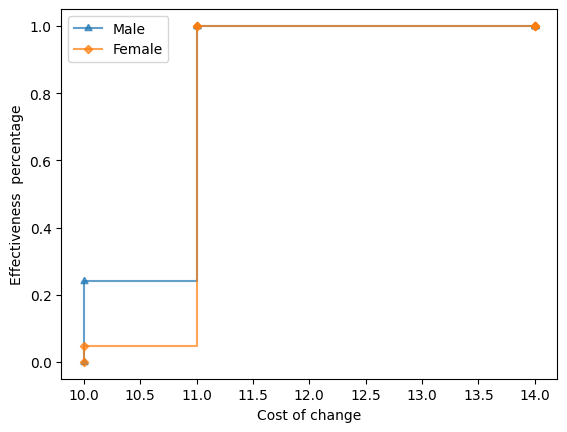

If ages = 25-34, homeowner = 1, income = Unknown, parents = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.66% covered out of 83109
		Make ages = 45-54 with effectiveness 24.22% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 55-64, homeowner = 0, income = <100K with effectiveness 100.00% and counterfactual cost = 14.0.
		Make ages = 55-64, homeowner = 0, income = >100K with effectiveness 100.00% and counterfactual cost = 14.0.
	Protected Subgroup 'Female', 1.63% covered out of 161494
		Make ages = 45-54 with effectiveness 5.20% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 55-64, homeowner = 0, income = <100K wi

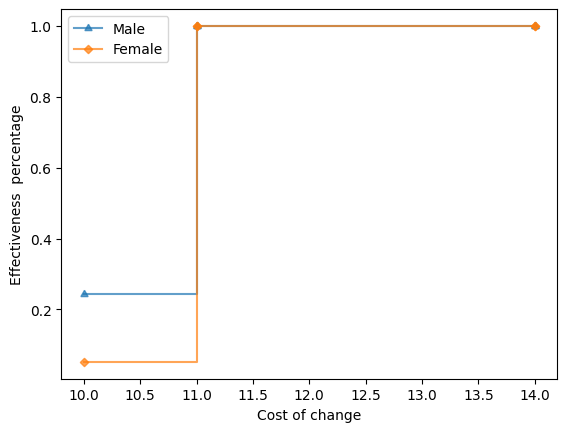

If ages = 25-34, college_educated = 1, income = Unknown, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.30% covered out of 83109
		Make ages = 55-64 with effectiveness 10.36% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.36% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 31.36% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 31.36% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 31.36% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 31.36% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 31.36% and counterfactual cost = 15.0.
		Make ages = 55-64, income = <100K, religion = Christianity with effectiveness 31.36% and counterfactual cost = 18.0.
		Make ages = 55-64, income = <100K, religion = Other with effectiveness 31.36% and co

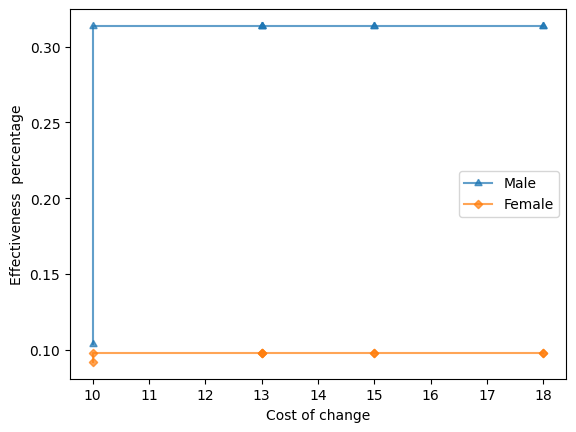

If ages = 25-34, income = Unknown, parents = 1, politics = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.29% covered out of 83109
		Make ages = 55-64 with effectiveness 10.44% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.97% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 31.97% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 31.97% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 31.97% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 31.97% and counterfactual cost = 15.0.
		Make ages = 55-64, income = <100K, religion = Christianity with effectiveness 31.97% and counterfactual cost = 18.0.
		Make ages = 55-64, income = <100K, religion = Other with effectiveness 31.97% and counterfactual cost = 18.0.
	Protected Subgroup 'Female', 1.24% covered out of 161494
		Make ages = 55-64 with 

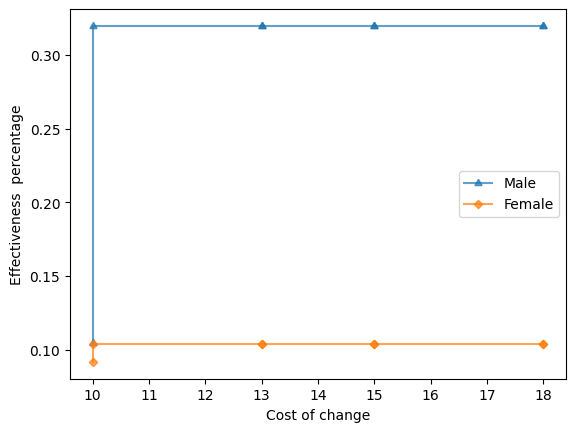

If ages = 25-34, college_educated = 1, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 1.28% covered out of 83109
		Make ages = 55-64 with effectiveness 12.30% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 33.24% and counterfactual cost = 10.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 33.24% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 33.24% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 33.24% and counterfactual cost = 15.0.
	Protected Subgroup 'Female', 1.25% covered out of 161494
		Make ages = 55-64 with effectiveness 11.37% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 11.67% and counterfactual cost = 10.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 11.67% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 11.67% and counterfactual cost = 15.0.
	

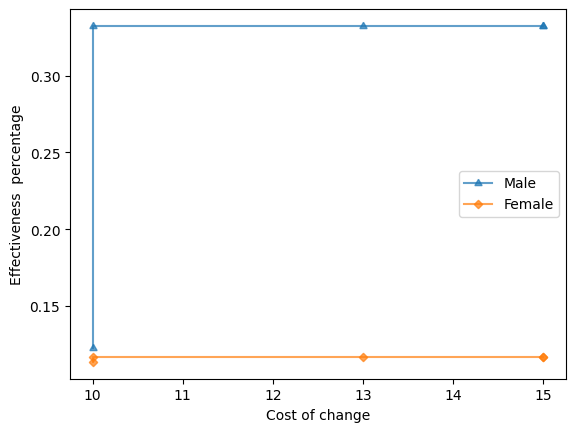

If ages = 25-34, homeowner = 1, parents = 1:
	Protected Subgroup 'Male', 1.72% covered out of 83109
		Make ages = 55-64 with effectiveness 0.07% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 23.88% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 99.86% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 99.86% and counterfactual cost = 11.0.
	Protected Subgroup 'Female', 1.69% covered out of 161494
		Make ages = 55-64 with effectiveness 0.04% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 5.41% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 5.66.
	Cumulative effectiveness plot for the above recourses:


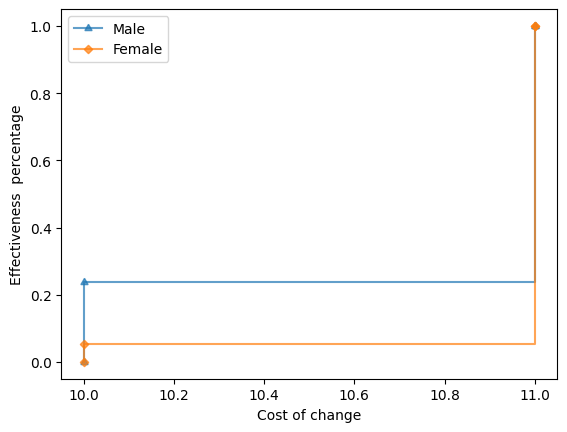

If ages = 25-34, college_educated = 1, homeowner = 1, politics = Unknown:
	Protected Subgroup 'Male', 1.71% covered out of 83109
		Make ages = 45-54 with effectiveness 22.43% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 95.78% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 55-64, politics = Moderate with effectiveness 100.00% and counterfactual cost = 12.0.
		Make ages = 55-64, college_educated = 0, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 14.0.
	Protected Subgroup 'Female', 1.68% covered out of 161494
		Make ages = 45-54 with effectiveness 3.91% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 97.13% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 55-64, politics = Moderate with effectiveness 100.00% 

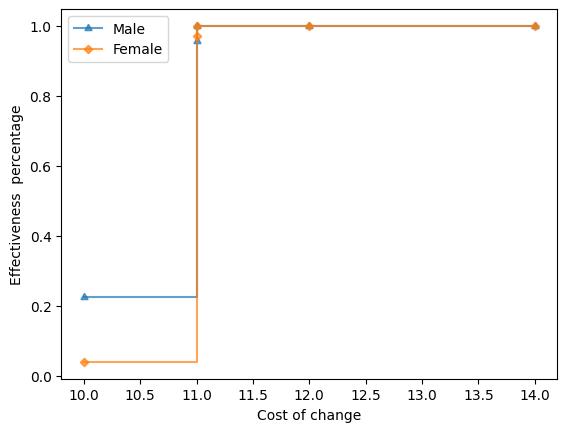

If ages = 25-34, college_educated = 1, income = Unknown, religion = Unknown:
	Protected Subgroup 'Male', 1.30% covered out of 83109
		Make ages = 55-64 with effectiveness 10.35% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.33% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 31.33% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 31.33% and counterfactual cost = 13.0.
		Make ages = 55-64, college_educated = 0 with effectiveness 31.33% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 31.33% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 31.33% and counterfactual cost = 15.0.
		Make ages = 55-64, income = <100K, religion = Christianity with effectiveness 31.33% and counterfactual cost = 18.0.
		Make ages = 55-64, income = <100K, religion = Other with effectiveness 31.33% and counterfactual cost = 

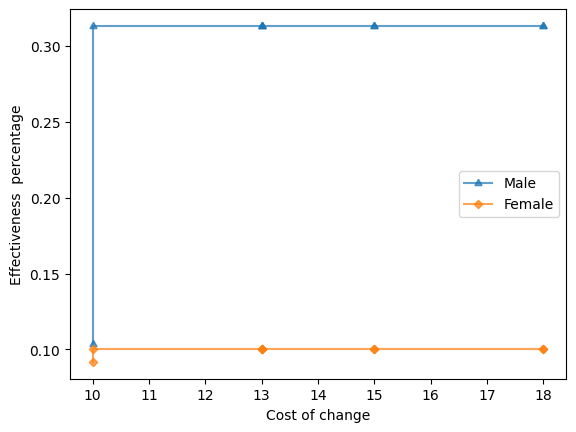

If ages = 25-34, homeowner = 1, income = Unknown, parents = 1:
	Protected Subgroup 'Male', 1.67% covered out of 83109
		Make ages = 55-64 with effectiveness 0.07% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 24.30% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 99.86% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 99.86% and counterfactual cost = 11.0.
		Make ages = 55-64, homeowner = 0, income = <100K with effectiveness 99.86% and counterfactual cost = 14.0.
		Make ages = 55-64, homeowner = 0, income = >100K with effectiveness 99.86% and counterfactual cost = 14.0.
	Protected Subgroup 'Female', 1.64% covered out of 161494
		Make ages = 55-64 with effectiveness 0.04% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 5.60% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 45-

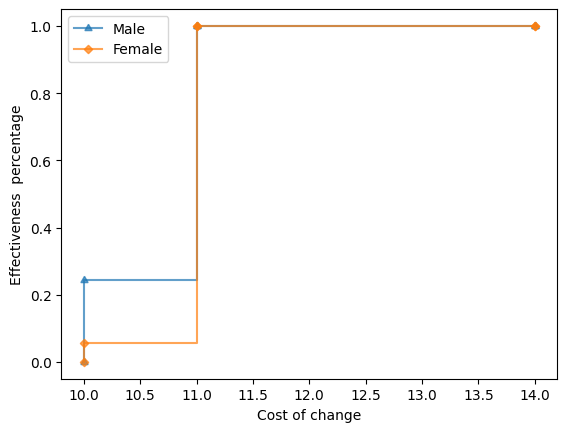

If ages = 25-34, college_educated = 1, homeowner = 1, income = Unknown, politics = Unknown:
	Protected Subgroup 'Male', 1.66% covered out of 83109
		Make ages = 45-54 with effectiveness 22.79% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 95.80% and counterfactual cost = 11.0.
		Make ages = 45-54, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 11.0.
		Make ages = 55-64, homeowner = 0, income = <100K with effectiveness 100.00% and counterfactual cost = 14.0.
		Make ages = 55-64, homeowner = 0, income = >100K with effectiveness 100.00% and counterfactual cost = 14.0.
		Make ages = 55-64, college_educated = 0, homeowner = 0 with effectiveness 100.00% and counterfactual cost = 14.0.
	Protected Subgroup 'Female', 1.62% covered out of 161494
		Make ages = 45-54 with effectiveness 4.04% and counterfactual cost = 10.0.
		Make ages = 55-64, homeowner = 0 with effectiveness 97.19% and counterfactual cost = 11.0.
		Make ages = 45-54, hom

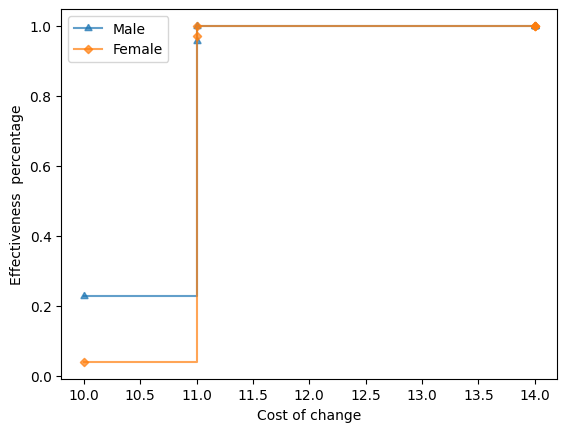

If ages = 25-34, income = Unknown, parents = 1, religion = Unknown:
	Protected Subgroup 'Male', 1.29% covered out of 83109
		Make ages = 55-64 with effectiveness 10.43% and counterfactual cost = 10.0.
		Make ages = 45-54 with effectiveness 31.94% and counterfactual cost = 10.0.
		Make ages = 55-64, income = <100K with effectiveness 31.94% and counterfactual cost = 13.0.
		Make ages = 55-64, income = >100K with effectiveness 31.94% and counterfactual cost = 13.0.
		Make ages = 55-64, religion = Christianity with effectiveness 31.94% and counterfactual cost = 15.0.
		Make ages = 55-64, religion = Other with effectiveness 31.94% and counterfactual cost = 15.0.
		Make ages = 55-64, income = <100K, religion = Christianity with effectiveness 31.94% and counterfactual cost = 18.0.
		Make ages = 55-64, income = <100K, religion = Other with effectiveness 31.94% and counterfactual cost = 18.0.
	Protected Subgroup 'Female', 1.24% covered out of 161494
		Make ages = 55-64 with effectiveness 9.14% 

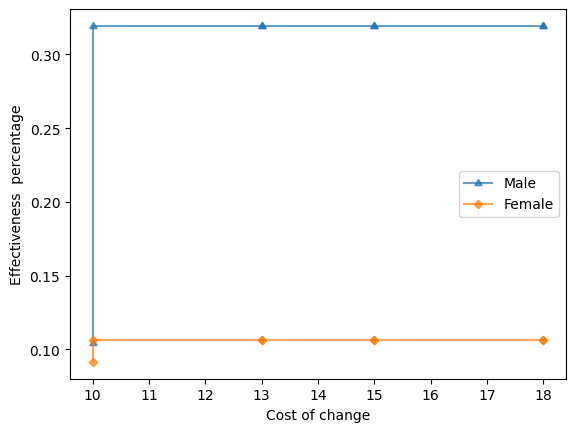

In [25]:
start_time = time.time()

affected_pop_sizes = {sg: ((X_test["gender"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["gender"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)

all_selections_time += time.time() - start_time

In [ ]:
all_selections_time

11.9510977268219

In [ ]:
stats["metrics-time"] = all_selections_time

In [ ]:
stats

{'freq-itemsets-no': {'Female': 1700, 'Male': 1658},
 'inter-groups-no': 1651,
 'unaff-freq-itemsets-no': 3476,
 'valid-if-thens-time': 613.3876247406006,
 'triples-no': 4274,
 'subgroup-no': 1280,
 'cumulative-time': 291.6053874492645,
 'metrics-time': 11.9510977268219}

In [ ]:
t = stats["valid-if-thens-time"] + stats["cumulative-time"] + stats["metrics-time"]
print(f"Total running time of our method = {t}")

Total running time of our method = 916.944109916687
